<table class="table table-bordered">
    <tr>
        <th style="text-align:center; width:25%"><img src='https://www.np.edu.sg/PublishingImages/Pages/default/odp/ICT.jpg' style="width: 250px; height: 125px; "></th>
        <th style="text-align:center;"><h1>Deep Learning</h1><h2>Assignment 2 (Problem 1) - Sentiment Analysis Model  (Group)</h2><h3>AY2022/23 Semester</h3></th>
    </tr>
</table>

In [1]:
# Import the Required Packages

import os
import nltk
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from keras.layers.convolutional import Conv1D    
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from tensorflow.keras import regularizers
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from nltk.stem import PorterStemmer, WordNetLemmatizer
from collections import Counter
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, SimpleRNN, Embedding, Flatten, ConvLSTM1D, MaxPooling1D
import warnings
warnings.filterwarnings("ignore") 

%matplotlib inline

# Table Of Contents  <a id="top"></a>
#### 1. [Data Loading and Processing](#part1)
   - [1.1 Data Loading](#part1.1)  
   - [1.2 Data Pre-processing](#part1.2)  
   - [1.3 Data Sampling](#part1.3) 
   
#### 2. [Develop a Sentiment Analysis Model](#part2)
       
#### 3. [Evaluate the Model using Testing Data](#part3)

#### 4. [Use the Best Model to make prediction](#part4)

## Step 1 – Data Loading and Processing (Group)<a id="part1"></a>

### 1.1 Data Loading <a id="part1.1"></a>

In [2]:
viki = pd.read_csv('viki.csv')
viki.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,642f2447-5bc6-4c7a-bb9c-ff4f86435873,Love Religion,https://play-lh.googleusercontent.com/a/AEdFTp...,Very bad,1,0,NaN,2023-01-10 13:51:28,NaN,NaN
1,5813398c-96d7-4033-9597-d57d18b1687b,SHRIKANT GANDHI,https://play-lh.googleusercontent.com/a/AEdFTp...,device information is ok to collect but no nee...,2,0,22.11.0,2023-01-10 11:55:50,Thanks for reaching out! For any questions or ...,2023-01-10 12:05:17
2,0987f83e-6493-4429-8ac6-aa91b1bdab56,Jeannette Capers,https://play-lh.googleusercontent.com/a-/AD5-W...,I was watching a movie then it just 🛑. I can't...,1,0,22.12.0,2023-01-10 11:02:45,We're sorry you're experiencing issues. Please...,2023-01-10 12:07:20
3,ce387a7a-2289-4553-9199-7dabbaee86b7,Kiri Giri,https://play-lh.googleusercontent.com/a/AEdFTp...,I love this app keep the K dramas coming espec...,5,0,NaN,2023-01-10 09:53:36,NaN,NaN
4,f7a133a5-b53f-4417-9b33-c1eeae754edb,diksha heera,https://play-lh.googleusercontent.com/a-/AD5-W...,I'm giving 2 stars because of Ads .. too much ...,3,0,22.11.2,2023-01-10 05:44:25,We're sorry you're experiencing issues. Please...,2023-01-10 12:07:52


In [3]:
viki.score.value_counts()

5    56040
4    15242
1    13945
3     9120
2     5853
Name: score, dtype: int64

In [4]:
viki = viki[['content', 'score']].copy()
viki.head()

,content,score
0,Very bad,1
1,device information is ok to collect but no nee...,2
2,I was watching a movie then it just 🛑. I can't...,1
3,I love this app keep the K dramas coming espec...,5
4,I'm giving 2 stars because of Ads .. too much ...,3


### 1.2 Data Processing <a id="part1.2"></a>


In [5]:
viki.isnull().sum()

content    264
score        0
dtype: int64

In [6]:
viki = viki.dropna()

In [7]:
def remove_non_english(string):
    return re.sub(r'[^\x00-\x7F]+','', string)

def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F" # emoticons
                           u"\U0001F300-\U0001F5FF" # symbols & pictographs
                           u"\U0001F680-\U0001F6FF" # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF" # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    
    return phrase

def cleantext(text):
    
    return re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)
    
def remove_whitespace(text):
  text = text.strip()
  return text

In [8]:
viki['content'] = viki['content'].apply(remove_non_english)
viki['content'] = viki['content'].apply(remove_emoji)
viki['content'] = viki['content'].apply(decontracted)
viki['content'] = viki['content'].apply(lambda x:cleantext(x))
viki['content'] = viki['content'].apply(remove_whitespace)   

#Remove numbers
viki['content'] = viki['content'].str.replace(r'\d', '')

In [9]:
viki.score.value_counts()

5    55866
4    15202
1    13919
3     9105
2     5844
Name: score, dtype: int64

In [10]:
def assign_sentiment(score):
    if score in [1, 2]:
        return 'negative'
    elif score == 3:
        return 'neutral'
    else:
        return 'positive'

viki['sentiments'] = viki['score'].apply(assign_sentiment)
viki.sentiments.value_counts()

positive    71068
negative    19763
neutral      9105
Name: sentiments, dtype: int64

In [11]:
viki = viki[viki['content'].str.len() >= 10]
viki.sentiments.value_counts()

positive    52192
negative    18725
neutral      8351
Name: sentiments, dtype: int64

In [12]:
def trim_string(string, n):
    return string[:n]

In [13]:
viki1=viki[viki['sentiments']=='negative']
viki1.head()

,content,score,sentiments
1,device information is ok to collect but no nee...,2,negative
2,I was watching a movie then it just I can not...,1,negative
10,Actually I give only one star because of a gli...,1,negative
11,He who greeds falls deep said no wise man ann...,1,negative
12,Nice app but ads are so many and we have to pa...,2,negative


In [14]:
viki2=viki[viki['sentiments']=='neutral']
viki2.head()

,content,score,sentiments
4,I am giving stars because of Ads too much an...,3,neutral
27,This is kinda good app,3,neutral
32,Is there dubbing versions of series,3,neutral
54,It is a really great app but my only problem i...,3,neutral
60,Too much paid shows,3,neutral


In [15]:
viki3=viki[viki['sentiments']=='positive']
viki3.head()

,content,score,sentiments
3,I love this app keep the K dramas coming espec...,5,positive
5,Great app Has all the best series,5,positive
6,Easy way to see my favorite dramas,5,positive
7,I am so glad these movies and shows are availa...,5,positive
8,Nice app from Pakistan,5,positive


In [16]:
viki1.sentiments.value_counts()

negative    18725
Name: sentiments, dtype: int64

In [17]:
viki2.sentiments.value_counts()

neutral    8351
Name: sentiments, dtype: int64

In [18]:
viki3.sentiments.value_counts()

positive    52192
Name: sentiments, dtype: int64

In [19]:
short_len = len(viki2)

viki1_sampled = viki1.sample(n=short_len, random_state=2).copy()
viki2_sampled = viki2.sample(n=short_len, random_state=2).copy()
viki3_sampled = viki3.sample(n=short_len, random_state=2).copy()

viki_final=pd.concat([viki1_sampled, viki2_sampled, viki3_sampled],axis=0)
viki_final['sentiments'].value_counts()

negative    8351
neutral     8351
positive    8351
Name: sentiments, dtype: int64

In [20]:
viki_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25053 entries, 89444 to 21843
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   content     25053 non-null  object
 1   score       25053 non-null  int64 
 2   sentiments  25053 non-null  object
dtypes: int64(1), object(2)
memory usage: 782.9+ KB


In [21]:
viki_final['content'] = viki_final['content'].astype(str)
viki_final['content'] = viki_final['content'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
viki_final['content'] = viki_final['content'].str.lower()
viki_final = viki_final[['content', 'sentiments']].copy()

In [22]:
viki_final.head(10)

,content,sentiments
89444,everhing is japan,negative
40166,i can not find anything that i like even if i ...,negative
47368,have not check yet good or bad change this rat...,negative
64592,it is ridiculous that now you have to pay to u...,negative
53608,they load dozens of ads into every show and th...,negative
63870,so many dramas are not available in europe tot...,negative
12782,does not even download,negative
25636,cant even watch it it says subscribe n watch s...,negative
39815,i just hate it really hate this appevery time ...,negative
21901,do not buy this app i bought a subscription fo...,negative


In [23]:
viki = viki_final.copy()

In [24]:
# Convert the content and scores into numeric tensors
texts = viki['content'].tolist()
label_encoder = LabelEncoder()
viki['sentiments'] = label_encoder.fit_transform(viki['sentiments'])
labels = viki['sentiments'].tolist()

# Preprocess the texts
stop_words = set(stopwords.words('english'))
exceptions = ["against", "no", "not", "nor", 'can', 'will', 'does']
add = ["app", "viki", "im"]
stop_words = stop_words - set(exceptions)
stop_words = stop_words | set(add)
stemmer = PorterStemmer()
lemma = WordNetLemmatizer()
preprocessed_texts = []
for text in texts:
    tokens = word_tokenize(text)
    tokens = [lemma.lemmatize(token) for token in tokens]
    preprocessed_text = " ".join(tokens)
    preprocessed_texts.append(preprocessed_text)
    
def remove_rare_words(texts, frequency_threshold=5):
    # Count the frequency of each word in the text data
    word_counter = Counter()
    for text in texts:
        word_counter.update(text.split())
        
    # Identify the rare words
    rare_words = set([word for word, count in word_counter.items() if count < frequency_threshold])
    
    # Remove the rare words from the text data
    filtered_texts = []
    for text in texts:
        filtered_text = ' '.join([word for word in text.split() if word not in rare_words])
        filtered_texts.append(filtered_text)
        
    return filtered_texts

preprocessed_texts = remove_rare_words(preprocessed_texts)

# Tokenize the texts and create a vocabulary
tokenizer = Tokenizer()
tokenizer.fit_on_texts(preprocessed_texts)
sequences = tokenizer.texts_to_sequences(preprocessed_texts)
vocab_size = len(tokenizer.word_index) + 1

# Pad the sequences to have the same length
max_length = max([len(s) for s in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_length)

# Create a categorical array for the labels
labels = to_categorical(labels)

### 1.3 Data Sampling <a id="part1.3"></a>

In [25]:
# Split the X & y into train and test sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.3, random_state=2)


In [26]:
X_train.shape, y_train.shape

((17537, 358), (17537, 3))

In [27]:
X_test.shape, y_test.shape

((7516, 358), (7516, 3))

## Step 2 – Develop a Sentiment Analysis Model (Individual: One Model Per Student) <a id="part2"></a>

### Model #1 <a id="model1"></a>

#### baseline model  : embedding dimension: 8, optimizer: rmsprop
[Back to Model Evaluation](#model1c)

In [109]:
# Build the model1vk

model1vk = Sequential()
model1vk.add(Embedding(vocab_size, 8, input_length=max_length))
model1vk.add(Flatten())
model1vk.add(Dense(3, activation='softmax'))

model1vk.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])
model1vk.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 358, 8)            23080     
                                                                 
 flatten (Flatten)           (None, 2864)              0         
                                                                 
 dense_2 (Dense)             (None, 3)                 8595      
                                                                 
Total params: 31,675
Trainable params: 31,675
Non-trainable params: 0
_________________________________________________________________


In [55]:
# Train the Model
history1vk = model1vk.fit(X_train, y_train, 
                          epochs=30, batch_size=25, 
                          validation_split=0.3)

Epoch 1/30
491/491 [==============================] - 3s 5ms/step - loss: 1.0177 - acc: 0.4572 - val_loss: 0.9168 - val_acc: 0.5528
Epoch 2/30
491/491 [==============================] - 2s 5ms/step - loss: 0.8635 - acc: 0.5934 - val_loss: 0.8423 - val_acc: 0.5973
Epoch 3/30
491/491 [==============================] - 2s 5ms/step - loss: 0.8034 - acc: 0.6347 - val_loss: 0.8199 - val_acc: 0.6161
Epoch 4/30
491/491 [==============================] - 2s 4ms/step - loss: 0.7698 - acc: 0.6558 - val_loss: 0.8094 - val_acc: 0.6260
Epoch 5/30
491/491 [==============================] - 2s 5ms/step - loss: 0.7458 - acc: 0.6681 - val_loss: 0.8077 - val_acc: 0.6241
Epoch 6/30
491/491 [==============================] - 3s 5ms/step - loss: 0.7260 - acc: 0.6807 - val_loss: 0.8174 - val_acc: 0.6195
Epoch 7/30
491/491 [==============================] - 2s 4ms/step - loss: 0.7093 - acc: 0.6920 - val_loss: 0.8101 - val_acc: 0.6281
Epoch 8/30
491/491 [==============================] - 2s 5ms/step - loss: 0.

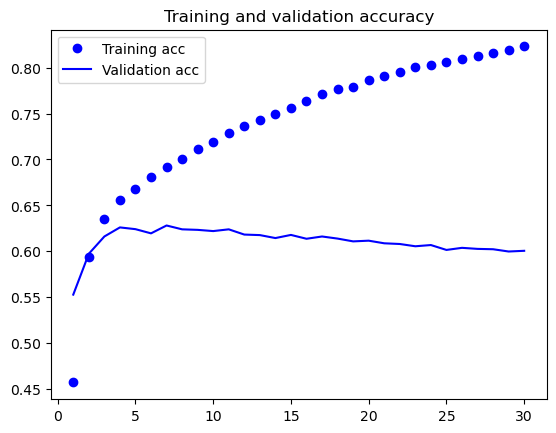

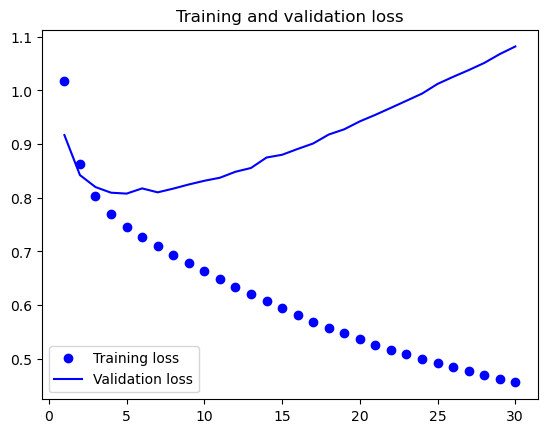

In [56]:
# Plot the Training and Validation Accuracy & Loss Scores

%matplotlib inline
import matplotlib.pyplot as plt

acc = history1vk.history['acc']
val_acc = history1vk.history['val_acc']
loss = history1vk.history['loss']
val_loss = history1vk.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [57]:
# Save the Model
model1vk.save('model1vk.h5')

### Model #2 <a id="model2"></a>

#### GRU
[Back to Model Evaluation](#model2c)


In [60]:
# Build the Model

model2vk = Sequential()
model2vk.add(Embedding(vocab_size, 8, input_length=max_length))
model2vk.add(GRU(32))
model2vk.add(Dense(3, activation='softmax'))

model2vk.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])
model2vk.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 355, 8)            21744     
                                                                 
 gru (GRU)                   (None, 32)                4032      
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 25,875
Trainable params: 25,875
Non-trainable params: 0
_________________________________________________________________


In [61]:
# Train the Model
history2vk = model2vk.fit(X_train, y_train, 
                          epochs=30, batch_size=25, 
                          validation_split=0.3)

Epoch 1/30
491/491 [==============================] - 74s 145ms/step - loss: 0.9625 - acc: 0.4921 - val_loss: 0.8805 - val_acc: 0.5431
Epoch 2/30
491/491 [==============================] - 71s 144ms/step - loss: 0.8517 - acc: 0.5780 - val_loss: 0.8314 - val_acc: 0.5891
Epoch 3/30
491/491 [==============================] - 84s 171ms/step - loss: 0.8232 - acc: 0.6001 - val_loss: 0.8235 - val_acc: 0.5950
Epoch 4/30
491/491 [==============================] - 90s 184ms/step - loss: 0.8100 - acc: 0.6144 - val_loss: 0.8120 - val_acc: 0.6078
Epoch 5/30
491/491 [==============================] - 66s 135ms/step - loss: 0.7816 - acc: 0.6357 - val_loss: 0.8071 - val_acc: 0.6241
Epoch 6/30
491/491 [==============================] - 64s 130ms/step - loss: 0.7485 - acc: 0.6592 - val_loss: 0.7882 - val_acc: 0.6302
Epoch 7/30
491/491 [==============================] - 71s 144ms/step - loss: 0.7297 - acc: 0.6741 - val_loss: 0.7823 - val_acc: 0.6406
Epoch 8/30
491/491 [==============================] - 6

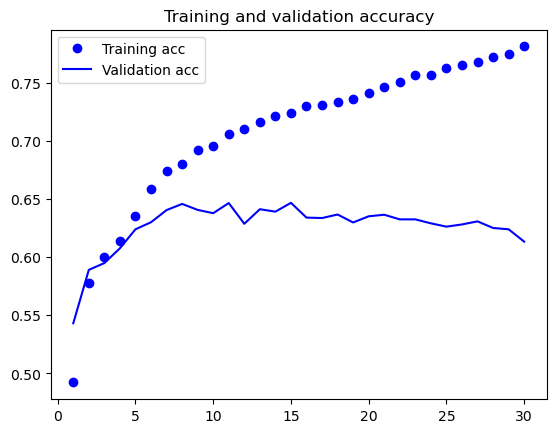

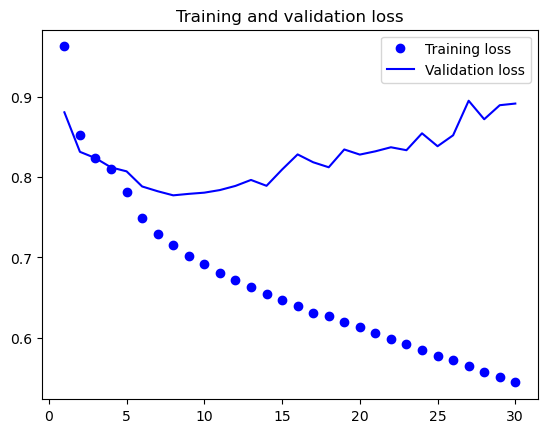

In [62]:
# Plot the Training and Validation Accuracy & Loss Scores

%matplotlib inline
import matplotlib.pyplot as plt

acc = history2vk.history['acc']
val_acc = history2vk.history['val_acc']
loss = history2vk.history['loss']
val_loss = history2vk.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [63]:
# Save the Model
model2vk.save('model2vk.h5')

### Model #3  <a id="model3"></a>

#### LSTM
[Back to Model Evaluation](#model3c)

In [103]:
# Build the Model

model3vk = Sequential()
model3vk.add(Embedding(vocab_size, 8, input_length=max_length))
model3vk.add(LSTM(32))
model3vk.add(Dense(3, activation='softmax'))

model3vk.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])
model3vk.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 355, 8)            21744     
                                                                 
 lstm_7 (LSTM)               (None, 32)                5248      
                                                                 
 dense_9 (Dense)             (None, 3)                 99        
                                                                 
Total params: 27,091
Trainable params: 27,091
Non-trainable params: 0
_________________________________________________________________


In [104]:
# Train the Model
history3vk = model3vk.fit(X_train, y_train, 
                          epochs=30, batch_size=25, 
                          validation_split=0.3)

Epoch 1/30
491/491 [==============================] - 83s 162ms/step - loss: 0.9656 - acc: 0.4927 - val_loss: 0.8634 - val_acc: 0.5705
Epoch 2/30
491/491 [==============================] - 70s 142ms/step - loss: 0.8438 - acc: 0.5837 - val_loss: 0.8163 - val_acc: 0.6009
Epoch 3/30
491/491 [==============================] - 62s 125ms/step - loss: 0.7933 - acc: 0.6275 - val_loss: 0.8040 - val_acc: 0.6138
Epoch 4/30
491/491 [==============================] - 61s 124ms/step - loss: 0.7949 - acc: 0.6349 - val_loss: 0.7923 - val_acc: 0.6249
Epoch 5/30
491/491 [==============================] - 68s 138ms/step - loss: 0.7607 - acc: 0.6565 - val_loss: 0.7963 - val_acc: 0.6243
Epoch 6/30
491/491 [==============================] - 63s 128ms/step - loss: 0.7507 - acc: 0.6617 - val_loss: 0.7842 - val_acc: 0.6389
Epoch 7/30
491/491 [==============================] - 60s 121ms/step - loss: 0.7269 - acc: 0.6794 - val_loss: 0.7782 - val_acc: 0.6452
Epoch 8/30
491/491 [==============================] - 6

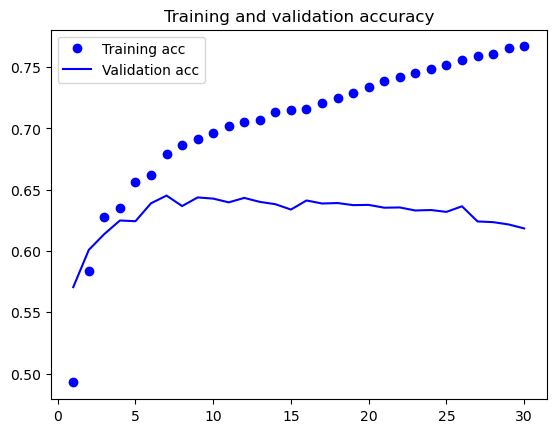

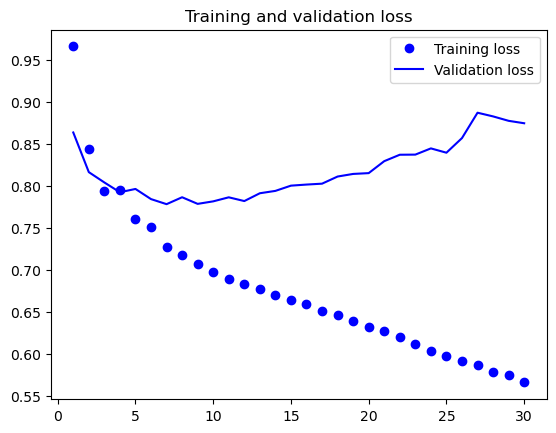

In [105]:
# Plot the Training and Validation Accuracy & Loss Scores

%matplotlib inline
import matplotlib.pyplot as plt

acc = history3vk.history['acc']
val_acc = history3vk.history['val_acc']
loss = history3vk.history['loss']
val_loss = history3vk.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [106]:
# Save the Model

model.save('model3vk.h5')

### Model #4 <a id="model4"></a>

#### SimpleRNN
[Back to Model Evaluation](#model4c)

In [71]:
# Build the Model

model4vk = Sequential()
model4vk.add(Embedding(vocab_size, 8, input_length=max_length))
model4vk.add(SimpleRNN(32))
model4vk.add(Dense(3, activation='softmax'))
model4vk.summary()

model4vk.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 355, 8)            21744     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                1312      
                                                                 
 dense_5 (Dense)             (None, 3)                 99        
                                                                 
Total params: 23,155
Trainable params: 23,155
Non-trainable params: 0
_________________________________________________________________


In [72]:
# Train the Model
history4vk = model4vk.fit(X_train, y_train, 
                          epochs=30, batch_size=25, 
                          validation_split=0.3)

Epoch 1/30
491/491 [==============================] - 54s 105ms/step - loss: 0.9900 - acc: 0.4736 - val_loss: 0.8933 - val_acc: 0.5526
Epoch 2/30
491/491 [==============================] - 45s 92ms/step - loss: 0.8654 - acc: 0.5753 - val_loss: 0.8480 - val_acc: 0.5796
Epoch 3/30
491/491 [==============================] - 48s 97ms/step - loss: 0.8122 - acc: 0.6168 - val_loss: 0.8353 - val_acc: 0.5897
Epoch 4/30
491/491 [==============================] - 49s 99ms/step - loss: 0.7692 - acc: 0.6496 - val_loss: 0.8433 - val_acc: 0.5962
Epoch 5/30
491/491 [==============================] - 45s 91ms/step - loss: 0.7374 - acc: 0.6743 - val_loss: 0.8406 - val_acc: 0.5977
Epoch 6/30
491/491 [==============================] - 47s 96ms/step - loss: 0.7184 - acc: 0.6846 - val_loss: 0.8545 - val_acc: 0.6015
Epoch 7/30
491/491 [==============================] - 47s 96ms/step - loss: 0.7249 - acc: 0.6822 - val_loss: 0.8617 - val_acc: 0.6022
Epoch 8/30
491/491 [==============================] - 48s 97m

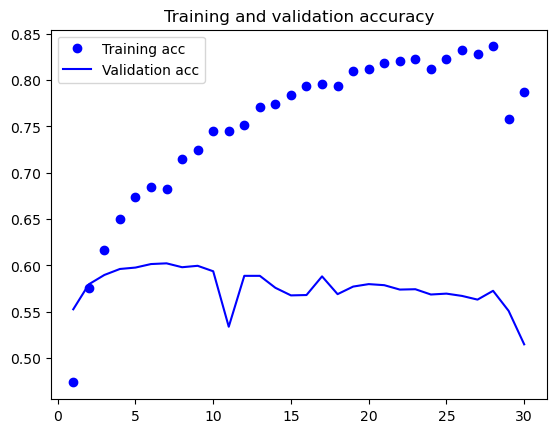

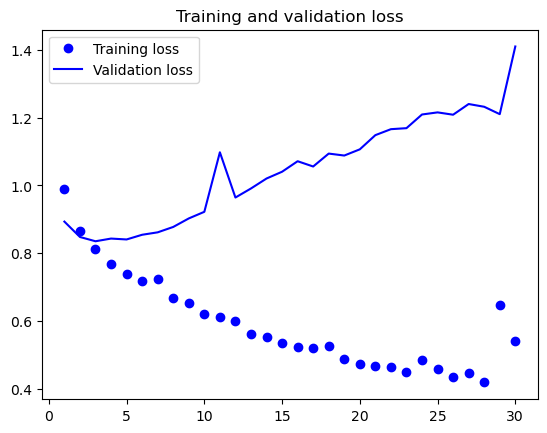

In [73]:
# Plot the Training and Validation Accuracy & Loss Scores

acc = history4vk.history['acc']
val_acc = history4vk.history['val_acc']
loss = history4vk.history['loss']
val_loss = history4vk.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [74]:
# Save the Model
model4vk.save('model4vk.h5')

### Model #5  <a id="model5"></a>

#### Conv1D + LSTM
[Back to Model Evaluation](#model5c)

In [90]:
# Build the Model

model5vk = Sequential()
model5vk.add(Embedding(vocab_size, 8, input_length=max_length))
model5vk.add(Conv1D(32, kernel_size=3))
model5vk.add(LSTM(32))
model5vk.add(Dense(3, activation='softmax'))

model5vk.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])
model5vk.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 355, 8)            21744     
                                                                 
 conv1d (Conv1D)             (None, 353, 32)           800       
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense_6 (Dense)             (None, 3)                 99        
                                                                 
Total params: 30,963
Trainable params: 30,963
Non-trainable params: 0
_________________________________________________________________


In [91]:
# Train the Model
history5vk = model5vk.fit(X_train, y_train, 
                          epochs=30, batch_size=25, 
                          validation_split=0.3)

Epoch 1/30
491/491 [==============================] - 72s 140ms/step - loss: 0.9371 - acc: 0.5113 - val_loss: 0.8493 - val_acc: 0.5730
Epoch 2/30
491/491 [==============================] - 66s 133ms/step - loss: 0.8323 - acc: 0.5923 - val_loss: 0.8169 - val_acc: 0.6040
Epoch 3/30
491/491 [==============================] - 69s 140ms/step - loss: 0.7914 - acc: 0.6329 - val_loss: 0.7922 - val_acc: 0.6231
Epoch 4/30
491/491 [==============================] - 75s 152ms/step - loss: 0.7792 - acc: 0.6478 - val_loss: 0.7932 - val_acc: 0.6296
Epoch 5/30
491/491 [==============================] - 84s 171ms/step - loss: 0.7675 - acc: 0.6486 - val_loss: 0.7815 - val_acc: 0.6370
Epoch 6/30
491/491 [==============================] - 83s 169ms/step - loss: 0.7334 - acc: 0.6739 - val_loss: 0.7831 - val_acc: 0.6349
Epoch 7/30
491/491 [==============================] - 81s 164ms/step - loss: 0.7215 - acc: 0.6824 - val_loss: 0.7820 - val_acc: 0.6410
Epoch 8/30
491/491 [==============================] - 8

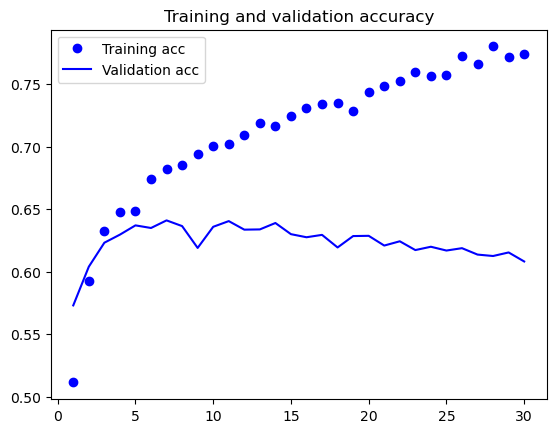

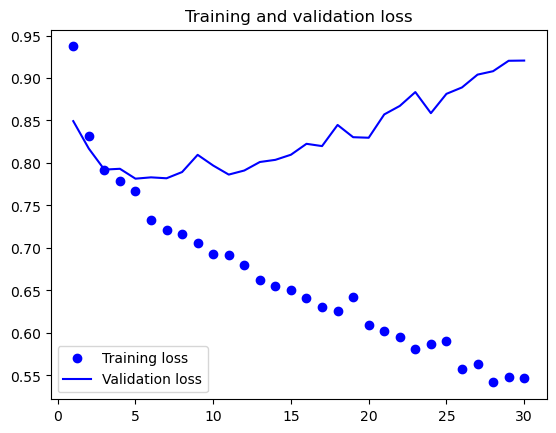

In [92]:
# Plot the Training and Validation Accuracy & Loss Scores

acc = history5vk.history['acc']
val_acc = history5vk.history['val_acc']
loss = history5vk.history['loss']
val_loss = history5vk.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [93]:
# Save the Model
model5vk.save('model5vk.h5')

### Model #6 <a id="model6"></a>

#### Learning rate: 0.001
[Back to Model Evaluation](#model6c)

In [110]:
# Build the Model

model6vk = Sequential()
model6vk.add(Embedding(vocab_size, 8, input_length=max_length))
model6vk.add(GRU(32))
model6vk.add(Dense(3, activation='softmax'))

model6vk.compile(loss='categorical_crossentropy', 
                 optimizer=optimizers.RMSprop(learning_rate=0.001), metrics=['acc'])
model6vk.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, 355, 8)            21744     
                                                                 
 gru_2 (GRU)                 (None, 32)                4032      
                                                                 
 dense_11 (Dense)            (None, 3)                 99        
                                                                 
Total params: 25,875
Trainable params: 25,875
Non-trainable params: 0
_________________________________________________________________


In [111]:
# Train the Model
history6vk = model6vk.fit(X_train, y_train, 
                          epochs=30, batch_size=25, 
                          validation_split=0.3)

Epoch 1/30
491/491 [==============================] - 94s 178ms/step - loss: 0.9653 - acc: 0.4915 - val_loss: 0.8632 - val_acc: 0.5623
Epoch 2/30
491/491 [==============================] - 88s 179ms/step - loss: 0.8491 - acc: 0.5744 - val_loss: 0.8361 - val_acc: 0.5914
Epoch 3/30
491/491 [==============================] - 94s 192ms/step - loss: 0.8099 - acc: 0.6181 - val_loss: 0.8031 - val_acc: 0.6169
Epoch 4/30
491/491 [==============================] - 93s 190ms/step - loss: 0.7708 - acc: 0.6487 - val_loss: 0.7985 - val_acc: 0.6298
Epoch 5/30
491/491 [==============================] - 58s 119ms/step - loss: 0.7489 - acc: 0.6618 - val_loss: 0.7851 - val_acc: 0.6357
Epoch 6/30
491/491 [==============================] - 76s 155ms/step - loss: 0.7334 - acc: 0.6732 - val_loss: 0.7775 - val_acc: 0.6403
Epoch 7/30
491/491 [==============================] - 115s 234ms/step - loss: 0.7189 - acc: 0.6829 - val_loss: 0.7837 - val_acc: 0.6370
Epoch 8/30
491/491 [==============================] - 

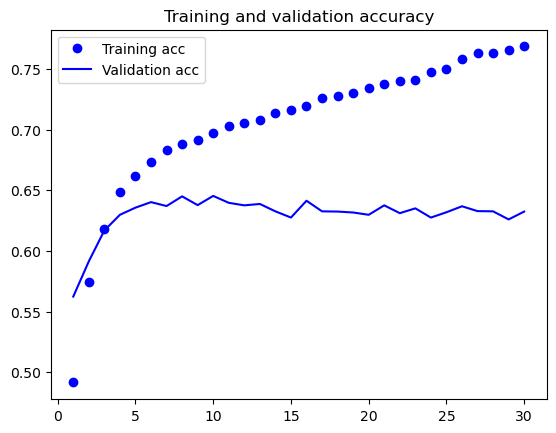

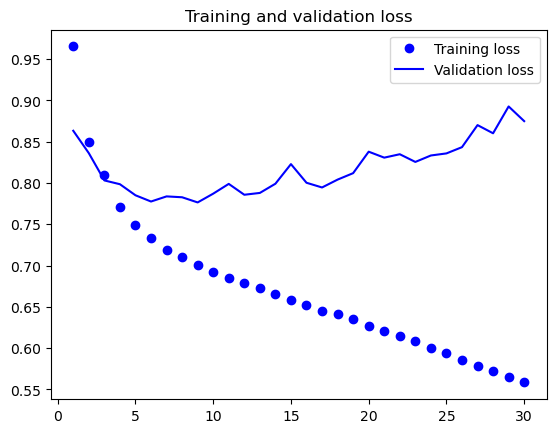

In [112]:
# Plot the Training and Validation Accuracy & Loss Scores

acc = history6vk.history['acc']
val_acc = history6vk.history['val_acc']
loss = history6vk.history['loss']
val_loss = history6vk.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [113]:
# Save the Model
model6vk.save('model6vk.h5')

### Model #7 <a id="model7"></a>

#### Learning rate: 0.0005
[Back to Model Evaluation](#model7c)

In [144]:
model7vk = Sequential()
model7vk.add(Embedding(vocab_size, 8, input_length=max_length))
model7vk.add(GRU(32))
model7vk.add(Dense(3, activation='softmax'))

model7vk.compile(loss='categorical_crossentropy', 
                 optimizer=optimizers.RMSprop(learning_rate=0.0005), metrics=['acc'])
model7vk.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_31 (Embedding)    (None, 355, 8)            21744     
                                                                 
 gru_20 (GRU)                (None, 32)                4032      
                                                                 
 dense_20 (Dense)            (None, 3)                 99        
                                                                 
Total params: 25,875
Trainable params: 25,875
Non-trainable params: 0
_________________________________________________________________


In [145]:
# Train the Model
history7vk = model7vk.fit(X_train, y_train, 
                          epochs=30, batch_size=25, 
                          validation_split=0.3)

Epoch 1/30
491/491 [==============================] - 75s 144ms/step - loss: 1.0154 - acc: 0.4492 - val_loss: 0.9092 - val_acc: 0.5200
Epoch 2/30
491/491 [==============================] - 76s 154ms/step - loss: 0.8743 - acc: 0.5529 - val_loss: 0.8538 - val_acc: 0.5728
Epoch 3/30
491/491 [==============================] - 65s 132ms/step - loss: 0.8421 - acc: 0.5813 - val_loss: 0.8360 - val_acc: 0.5783
Epoch 4/30
491/491 [==============================] - 78s 159ms/step - loss: 0.8263 - acc: 0.5886 - val_loss: 0.8265 - val_acc: 0.5914
Epoch 5/30
491/491 [==============================] - 61s 123ms/step - loss: 0.8125 - acc: 0.6021 - val_loss: 0.8229 - val_acc: 0.5975
Epoch 6/30
491/491 [==============================] - 64s 131ms/step - loss: 0.8029 - acc: 0.6138 - val_loss: 0.8283 - val_acc: 0.5948
Epoch 7/30
491/491 [==============================] - 56s 115ms/step - loss: 0.7965 - acc: 0.6192 - val_loss: 0.8211 - val_acc: 0.5929
Epoch 8/30
491/491 [==============================] - 5

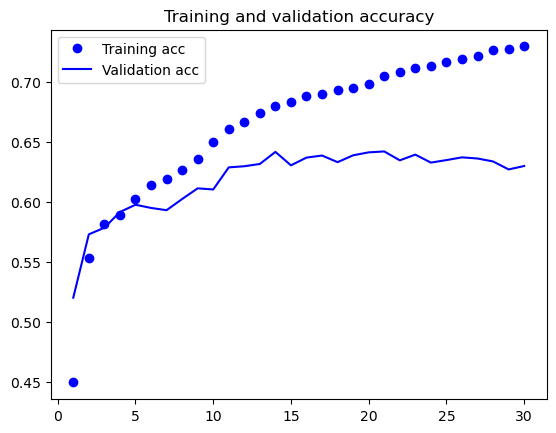

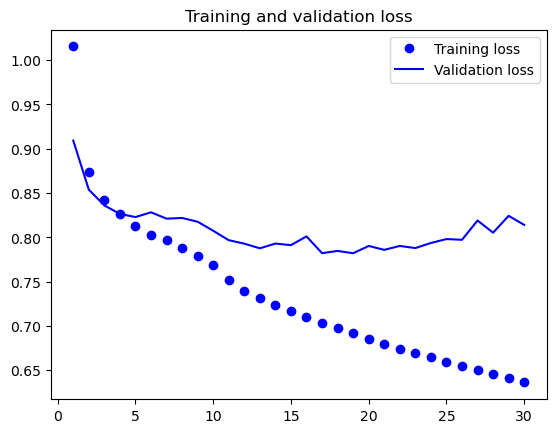

In [146]:
# Plot the Training and Validation Accuracy & Loss Scores

acc = history7vk.history['acc']
val_acc = history7vk.history['val_acc']
loss = history7vk.history['loss']
val_loss = history7vk.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [147]:
# Save the Model
model7vk.save('model7vk.h5')

### Model #8 <a id="model8"></a>

#### 2 GRU Layers
[Back to Model Evaluation](#model8c)

In [149]:
# Build the Model

model8vk = Sequential()
model8vk.add(Embedding(vocab_size, 8, input_length=max_length))
model8vk.add(GRU(32, return_sequences= True))
model8vk.add(GRU(32))
model8vk.add(Dense(3, activation='softmax'))

model8vk.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(learning_rate=0.0005), metrics=['acc'])
model8vk.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_32 (Embedding)    (None, 355, 8)            21744     
                                                                 
 gru_21 (GRU)                (None, 355, 32)           4032      
                                                                 
 gru_22 (GRU)                (None, 32)                6336      
                                                                 
 dense_21 (Dense)            (None, 3)                 99        
                                                                 
Total params: 32,211
Trainable params: 32,211
Non-trainable params: 0
_________________________________________________________________


In [150]:
# Train the Model
history8vk = model8vk.fit(X_train, y_train, 
                          epochs=20, batch_size=25, 
                          validation_split=0.3)

Epoch 1/20
491/491 [==============================] - 127s 250ms/step - loss: 0.9947 - acc: 0.4653 - val_loss: 0.8836 - val_acc: 0.5604
Epoch 2/20
491/491 [==============================] - 116s 237ms/step - loss: 0.8654 - acc: 0.5612 - val_loss: 0.8471 - val_acc: 0.5846
Epoch 3/20
491/491 [==============================] - 137s 279ms/step - loss: 0.8242 - acc: 0.6014 - val_loss: 0.8401 - val_acc: 0.5948
Epoch 4/20
491/491 [==============================] - 148s 302ms/step - loss: 0.7950 - acc: 0.6269 - val_loss: 0.8114 - val_acc: 0.6184
Epoch 5/20
491/491 [==============================] - 144s 293ms/step - loss: 0.7787 - acc: 0.6446 - val_loss: 0.8120 - val_acc: 0.6142
Epoch 6/20
491/491 [==============================] - 135s 275ms/step - loss: 0.7639 - acc: 0.6548 - val_loss: 0.8161 - val_acc: 0.6123
Epoch 7/20
491/491 [==============================] - 130s 264ms/step - loss: 0.7503 - acc: 0.6618 - val_loss: 0.7956 - val_acc: 0.6309
Epoch 8/20
491/491 [============================

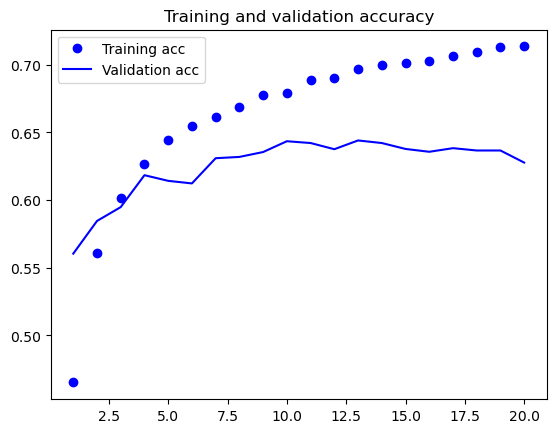

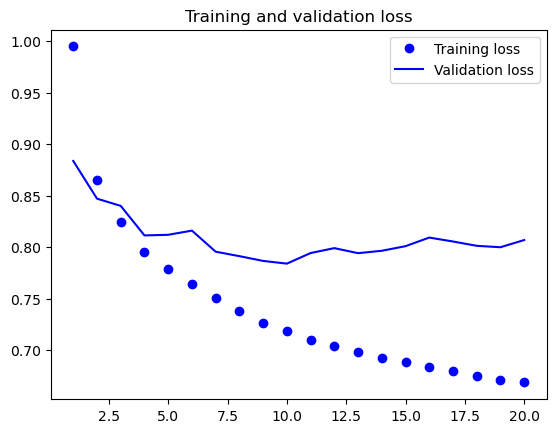

In [151]:
# Plot the Training and Validation Accuracy & Loss Scores

acc = history8vk.history['acc']
val_acc = history8vk.history['val_acc']
loss = history8vk.history['loss']
val_loss = history8vk.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [152]:
# Save the Model
model8vk.save('model8vk.h5')

### Model #9 <a id="model9"></a>

#### Increase units in GRU layers (32,64)
[Back to Model Evaluation](#model9c)

In [159]:
model9vk = Sequential()
model9vk.add(Embedding(vocab_size, 8, input_length=max_length))
model9vk.add(GRU(32,return_sequences= True))
model9vk.add(GRU(64))
model9vk.add(Dense(3, activation='softmax'))

model9vk.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(learning_rate=0.0005), metrics=['acc'])
model9vk.summary()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_36 (Embedding)    (None, 355, 8)            21744     
                                                                 
 gru_31 (GRU)                (None, 355, 32)           4032      
                                                                 
 gru_32 (GRU)                (None, 64)                18816     
                                                                 
 dense_25 (Dense)            (None, 3)                 195       
                                                                 
Total params: 44,787
Trainable params: 44,787
Non-trainable params: 0
_________________________________________________________________


In [160]:
history9vk = model9vk.fit(X_train, y_train, 
                          epochs=20, batch_size=25, 
                          validation_split=0.3)

Epoch 1/20
491/491 [==============================] - 155s 304ms/step - loss: 0.9919 - acc: 0.4645 - val_loss: 0.8888 - val_acc: 0.5487
Epoch 2/20
491/491 [==============================] - 137s 280ms/step - loss: 0.8671 - acc: 0.5643 - val_loss: 0.8549 - val_acc: 0.5800
Epoch 3/20
491/491 [==============================] - 128s 260ms/step - loss: 0.8275 - acc: 0.6004 - val_loss: 0.8233 - val_acc: 0.6011
Epoch 4/20
491/491 [==============================] - 143s 291ms/step - loss: 0.7967 - acc: 0.6276 - val_loss: 0.8319 - val_acc: 0.5956
Epoch 5/20
491/491 [==============================] - 129s 263ms/step - loss: 0.7791 - acc: 0.6422 - val_loss: 0.8057 - val_acc: 0.6176
Epoch 6/20
491/491 [==============================] - 125s 254ms/step - loss: 0.7595 - acc: 0.6562 - val_loss: 0.7903 - val_acc: 0.6306
Epoch 7/20
491/491 [==============================] - 123s 250ms/step - loss: 0.7459 - acc: 0.6618 - val_loss: 0.7887 - val_acc: 0.6351
Epoch 8/20
491/491 [============================

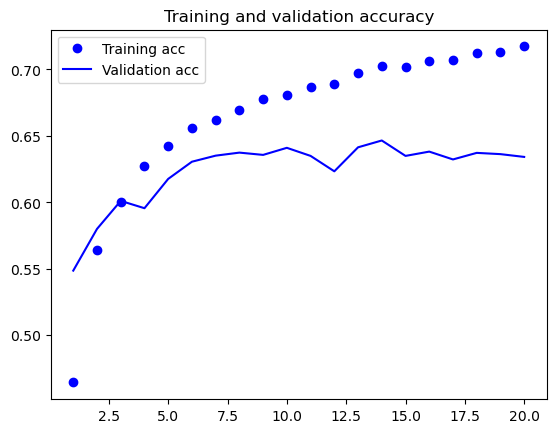

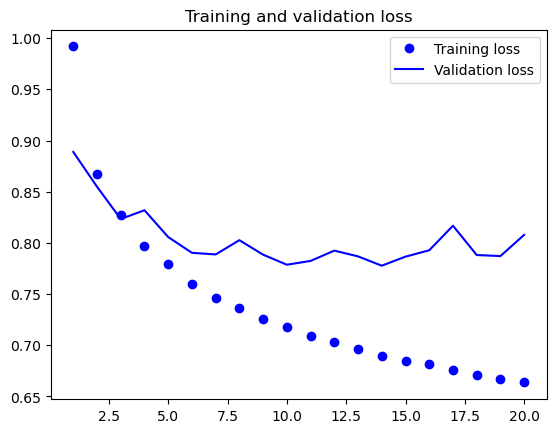

In [161]:
# Plot the Training and Validation Accuracy & Loss Scores

acc = history9vk.history['acc']
val_acc = history9vk.history['val_acc']
loss = history9vk.history['loss']
val_loss = history9vk.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [162]:
# Save the Model
model9vk.save('model9vk.h5')

### Model #10 <a id="model10"></a>

#### Increase units in GRU layer (64,128)
[Back to Model Evaluation](#model10c)

In [63]:
model10vk = Sequential()
model10vk.add(Embedding(vocab_size, 8, input_length=max_length))
model10vk.add(GRU(64, return_sequences=True))
model10vk.add(GRU(128))
model10vk.add(Dense(3, activation='softmax'))

model10vk.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(learning_rate=0.0005), metrics=['acc'])
model10vk.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 358, 8)            23080     
                                                                 
 gru_12 (GRU)                (None, 358, 64)           14208     
                                                                 
 gru_13 (GRU)                (None, 128)               74496     
                                                                 
 dense_13 (Dense)            (None, 3)                 387       
                                                                 
Total params: 112,171
Trainable params: 112,171
Non-trainable params: 0
_________________________________________________________________


In [64]:
history10vk = model10vk.fit(X_train, y_train, 
                          epochs=20, batch_size=25, 
                          validation_split=0.3)

Epoch 1/20
491/491 [==============================] - 181s 363ms/step - loss: 0.9934 - acc: 0.4651 - val_loss: 0.8915 - val_acc: 0.5519
Epoch 2/20
491/491 [==============================] - 191s 390ms/step - loss: 0.8694 - acc: 0.5667 - val_loss: 0.8755 - val_acc: 0.5616
Epoch 3/20
491/491 [==============================] - 175s 356ms/step - loss: 0.8275 - acc: 0.6091 - val_loss: 0.8201 - val_acc: 0.6028
Epoch 4/20
491/491 [==============================] - 176s 359ms/step - loss: 0.8005 - acc: 0.6277 - val_loss: 0.8192 - val_acc: 0.6064
Epoch 5/20
491/491 [==============================] - 176s 359ms/step - loss: 0.7784 - acc: 0.6461 - val_loss: 0.8076 - val_acc: 0.6209
Epoch 6/20
491/491 [==============================] - 177s 361ms/step - loss: 0.7564 - acc: 0.6612 - val_loss: 0.8259 - val_acc: 0.6193
Epoch 7/20
491/491 [==============================] - 180s 366ms/step - loss: 0.7397 - acc: 0.6679 - val_loss: 0.8000 - val_acc: 0.6252
Epoch 8/20
491/491 [============================

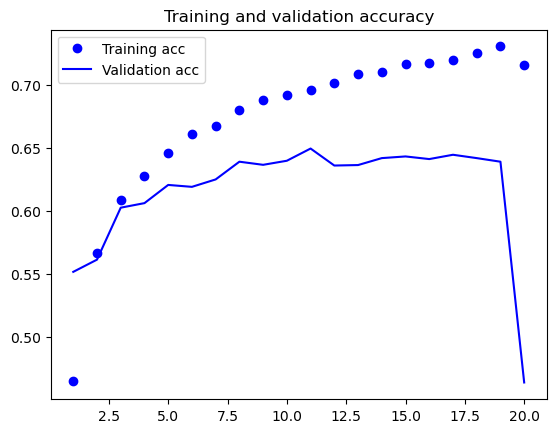

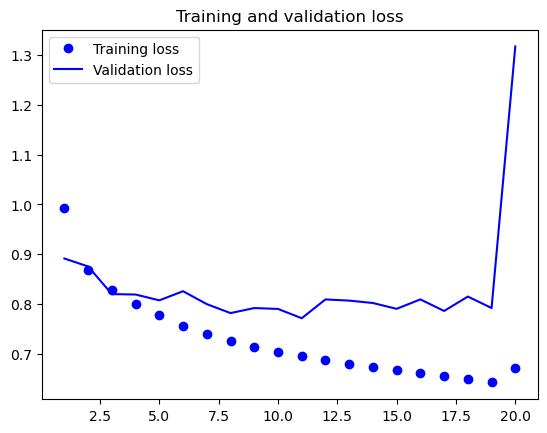

In [65]:
# Plot the Training and Validation Accuracy & Loss Scores

acc = history10vk.history['acc']
val_acc = history10vk.history['val_acc']
loss = history10vk.history['loss']
val_loss = history10vk.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [66]:
# Save the Model
model10vk.save('model10vk.h5')

### Model #11<a id="model11"></a>

#### Add another dense layer of 32 units
[Back to Model Evaluation](#model11c)

In [25]:
model11vk = Sequential()
model11vk.add(Embedding(vocab_size, 8, input_length=max_length))
model11vk.add(GRU(32, return_sequences=True))
model11vk.add(GRU(64))
model11vk.add(Dense(32, activation='relu'))
model11vk.add(Dense(3, activation='softmax'))

model11vk.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(learning_rate=0.0005), metrics=['acc'])
model11vk.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 358, 8)            23080     
                                                                 
 gru (GRU)                   (None, 358, 32)           4032      
                                                                 
 gru_1 (GRU)                 (None, 64)                18816     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                                 
Total params: 48,107
Trainable params: 48,107
Non-trainable params: 0
_________________________________________________________________


In [32]:
history11vk = model11vk.fit(X_train, y_train, 
                          epochs=20, batch_size=25, 
                          validation_split=0.3)

Epoch 1/20
491/491 [==============================] - 108s 213ms/step - loss: 0.9880 - acc: 0.4626 - val_loss: 0.8875 - val_acc: 0.5515
Epoch 2/20
491/491 [==============================] - 98s 200ms/step - loss: 0.8710 - acc: 0.5554 - val_loss: 0.8475 - val_acc: 0.5716
Epoch 3/20
491/491 [==============================] - 96s 195ms/step - loss: 0.8365 - acc: 0.5849 - val_loss: 0.8845 - val_acc: 0.5469
Epoch 4/20
491/491 [==============================] - 108s 220ms/step - loss: 0.8178 - acc: 0.6012 - val_loss: 0.8240 - val_acc: 0.5975
Epoch 5/20
491/491 [==============================] - 99s 201ms/step - loss: 0.7986 - acc: 0.6242 - val_loss: 0.8173 - val_acc: 0.6074
Epoch 6/20
491/491 [==============================] - 100s 204ms/step - loss: 0.7756 - acc: 0.6459 - val_loss: 0.8140 - val_acc: 0.6129
Epoch 7/20
491/491 [==============================] - 94s 192ms/step - loss: 0.7598 - acc: 0.6532 - val_loss: 0.8045 - val_acc: 0.6237
Epoch 8/20
491/491 [==============================] 

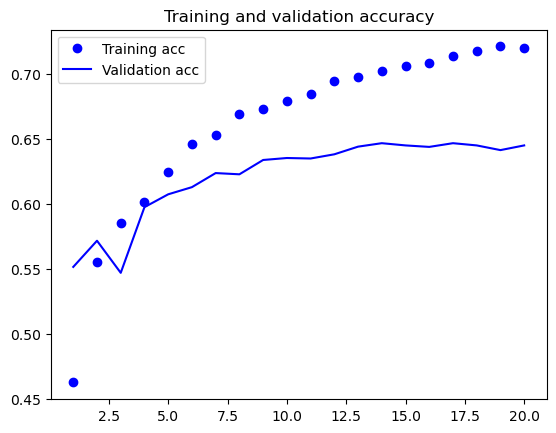

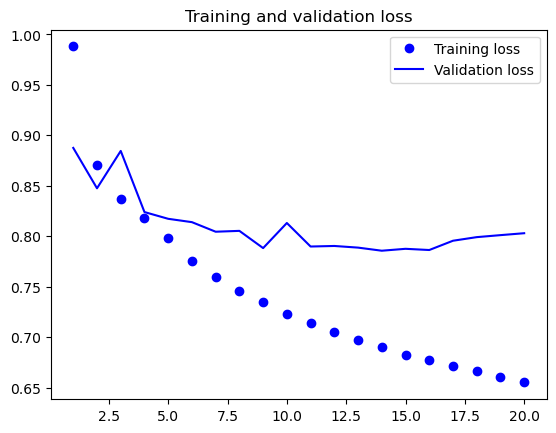

In [33]:
# Plot the Training and Validation Accuracy & Loss Scores

acc = history11vk.history['acc']
val_acc = history11vk.history['val_acc']
loss = history11vk.history['loss']
val_loss = history11vk.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [34]:
# Save the Model
model11vk.save('model11vk.h5')

### Model #12 <a id="model12"></a>

#### Add 2 more dense layer of 64 and 32 units
[Back to Model Evaluation](#model12c)

In [43]:
model12vk = Sequential()
model12vk.add(Embedding(vocab_size, 8, input_length=max_length))
model12vk.add(GRU(32, return_sequences=True))
model12vk.add(GRU(64))

model12vk.add(Dense(64, activation='relu'))
model11vk.add(Dense(32, activation='relu'))
model12vk.add(Dense(3, activation='softmax'))

model12vk.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(learning_rate=0.0005), metrics=['acc'])
model12vk.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 358, 8)            23080     
                                                                 
 gru_6 (GRU)                 (None, 358, 32)           4032      
                                                                 
 gru_7 (GRU)                 (None, 64)                18816     
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 3)                 195       
                                                                 
Total params: 50,283
Trainable params: 50,283
Non-trainable params: 0
_________________________________________________________________


In [44]:
history12vk = model12vk.fit(X_train, y_train, 
                          epochs=20, batch_size=25, 
                          validation_split=0.3)

Epoch 1/20
491/491 [==============================] - 114s 224ms/step - loss: 1.0008 - acc: 0.4600 - val_loss: 0.8768 - val_acc: 0.5532
Epoch 2/20
491/491 [==============================] - 122s 248ms/step - loss: 0.8642 - acc: 0.5653 - val_loss: 0.8411 - val_acc: 0.5800
Epoch 3/20
491/491 [==============================] - 143s 290ms/step - loss: 0.8307 - acc: 0.5927 - val_loss: 0.8309 - val_acc: 0.5914
Epoch 4/20
491/491 [==============================] - 141s 287ms/step - loss: 0.8057 - acc: 0.6196 - val_loss: 0.8420 - val_acc: 0.5962
Epoch 5/20
491/491 [==============================] - 124s 252ms/step - loss: 0.7785 - acc: 0.6451 - val_loss: 0.8035 - val_acc: 0.6218
Epoch 6/20
491/491 [==============================] - 128s 260ms/step - loss: 0.7558 - acc: 0.6585 - val_loss: 0.8024 - val_acc: 0.6279
Epoch 7/20
491/491 [==============================] - 147s 300ms/step - loss: 0.7367 - acc: 0.6714 - val_loss: 0.7958 - val_acc: 0.6306
Epoch 8/20
491/491 [============================

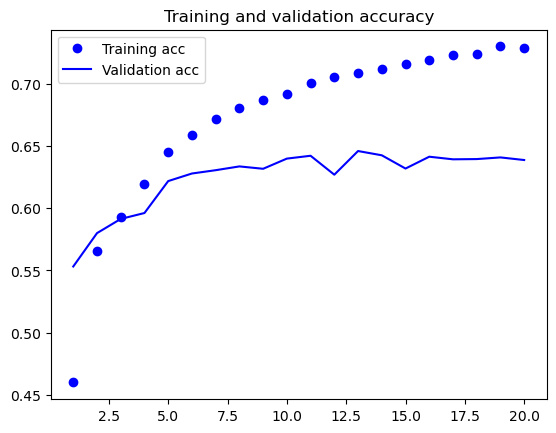

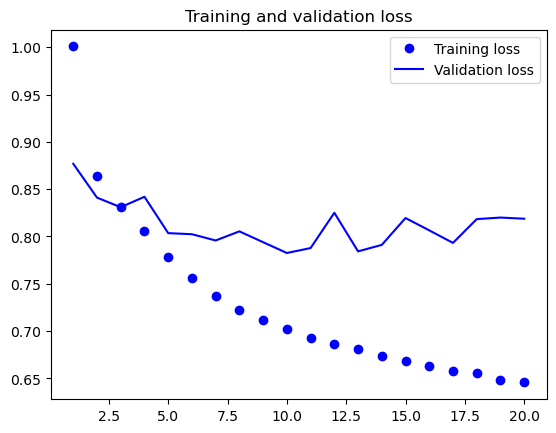

In [45]:
# Plot the Training and Validation Accuracy & Loss Scores

acc = history12vk.history['acc']
val_acc = history12vk.history['val_acc']
loss = history12vk.history['loss']
val_loss = history12vk.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [46]:
# Save the Model
model12vk.save('model12vk.h5')

### Model #13 <a id="model13"></a>

#### Dropout: 0.2
[Back to Model Evaluation](#model13c)

In [48]:
model13vk = Sequential()
model13vk.add(Embedding(vocab_size, 8, input_length=max_length))
model13vk.add(GRU(32, return_sequences=True))
model13vk.add(layers.Dropout(0.2))
model13vk.add(GRU(64))
model13vk.add(layers.Dropout(0.2))
model13vk.add(Dense(32, activation='relu'))
model13vk.add(Dense(3, activation='softmax'))

model13vk.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(learning_rate=0.0005), metrics=['acc'])
model13vk.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 358, 8)            23080     
                                                                 
 gru_8 (GRU)                 (None, 358, 32)           4032      
                                                                 
 dropout (Dropout)           (None, 358, 32)           0         
                                                                 
 gru_9 (GRU)                 (None, 64)                18816     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dense_10 (Dense)            (None, 3)                

In [49]:
history13vk = model13vk.fit(X_train, y_train, 
                          epochs=20, batch_size=25, 
                          validation_split=0.3)

Epoch 1/20
491/491 [==============================] - 158s 314ms/step - loss: 0.9918 - acc: 0.4707 - val_loss: 0.8915 - val_acc: 0.5487
Epoch 2/20
491/491 [==============================] - 117s 238ms/step - loss: 0.8703 - acc: 0.5552 - val_loss: 0.8461 - val_acc: 0.5734
Epoch 3/20
491/491 [==============================] - 119s 242ms/step - loss: 0.8409 - acc: 0.5811 - val_loss: 0.8397 - val_acc: 0.5840
Epoch 4/20
491/491 [==============================] - 138s 282ms/step - loss: 0.8206 - acc: 0.6036 - val_loss: 0.8272 - val_acc: 0.5929
Epoch 5/20
491/491 [==============================] - 125s 255ms/step - loss: 0.8060 - acc: 0.6145 - val_loss: 0.8253 - val_acc: 0.5962
Epoch 6/20
491/491 [==============================] - 136s 278ms/step - loss: 0.7874 - acc: 0.6330 - val_loss: 0.8357 - val_acc: 0.6108
Epoch 7/20
491/491 [==============================] - 124s 252ms/step - loss: 0.7702 - acc: 0.6483 - val_loss: 0.8093 - val_acc: 0.6174
Epoch 8/20
491/491 [============================

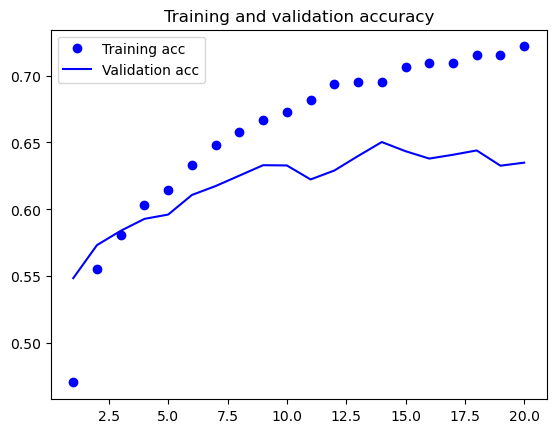

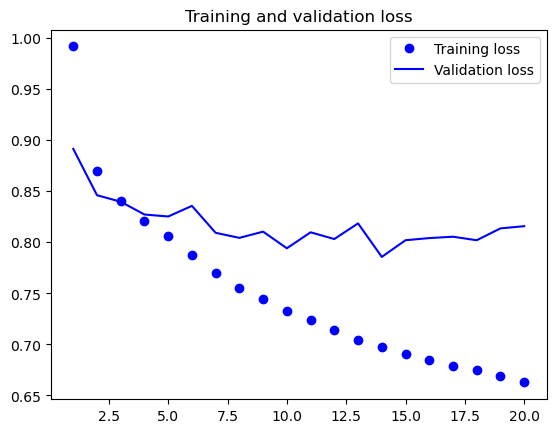

In [50]:
# Plot the Training and Validation Accuracy & Loss Scores

acc = history13vk.history['acc']
val_acc = history13vk.history['val_acc']
loss = history13vk.history['loss']
val_loss = history13vk.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [51]:
# Save the Model
model13vk.save('model13vk.h5')

### Model #14 <a id="model14"></a>

#### Dropout: 0.2, No. of Dropout Layer: 1 
[Back to Model Evaluation](#model14c)

In [75]:
model14vk = Sequential()
model14vk.add(Embedding(vocab_size, 8, input_length=max_length))
model14vk.add(GRU(32, return_sequences=True))
model14vk.add(layers.Dropout(0.2))
model14vk.add(GRU(64))
model14vk.add(Dense(32, activation='relu'))
model14vk.add(Dense(3, activation='softmax'))

model14vk.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(learning_rate=0.0005), metrics=['acc'])
model14vk.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 358, 8)            23080     
                                                                 
 gru_18 (GRU)                (None, 358, 32)           4032      
                                                                 
 dropout_7 (Dropout)         (None, 358, 32)           0         
                                                                 
 gru_19 (GRU)                (None, 64)                18816     
                                                                 
 dense_18 (Dense)            (None, 32)                2080      
                                                                 
 dense_19 (Dense)            (None, 3)                 99        
                                                                 
Total params: 48,107
Trainable params: 48,107
Non-trai

In [76]:
history14vk = model14vk.fit(X_train, y_train, 
                          epochs=20, batch_size=25, 
                          validation_split=0.3)

Epoch 1/20
491/491 [==============================] - 235s 396ms/step - loss: 1.0194 - acc: 0.4409 - val_loss: 0.8931 - val_acc: 0.5538
Epoch 2/20
491/491 [==============================] - 106s 215ms/step - loss: 0.8714 - acc: 0.5628 - val_loss: 0.8518 - val_acc: 0.5758
Epoch 3/20
491/491 [==============================] - 108s 219ms/step - loss: 0.8351 - acc: 0.5904 - val_loss: 0.8431 - val_acc: 0.5808
Epoch 4/20
491/491 [==============================] - 103s 210ms/step - loss: 0.8035 - acc: 0.6204 - val_loss: 0.8246 - val_acc: 0.6055
Epoch 5/20
491/491 [==============================] - 115s 235ms/step - loss: 0.7761 - acc: 0.6435 - val_loss: 0.8172 - val_acc: 0.6148
Epoch 6/20
491/491 [==============================] - 193s 394ms/step - loss: 0.7546 - acc: 0.6582 - val_loss: 0.7974 - val_acc: 0.6338
Epoch 7/20
491/491 [==============================] - 189s 385ms/step - loss: 0.7393 - acc: 0.6719 - val_loss: 0.7952 - val_acc: 0.6345
Epoch 8/20
491/491 [============================

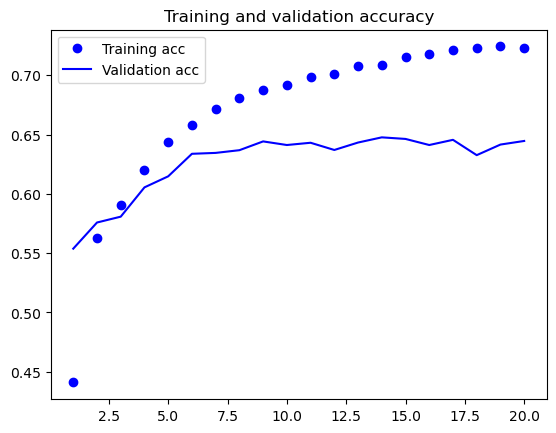

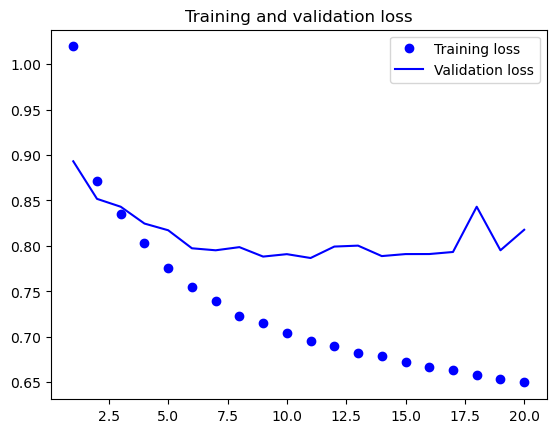

In [77]:
# Plot the Training and Validation Accuracy & Loss Scores

acc = history14vk.history['acc']
val_acc = history14vk.history['val_acc']
loss = history14vk.history['loss']
val_loss = history14vk.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [78]:
# Save the Model
model14vk.save('model14vk.h5')

### Model #15 <a id="model15"></a>

#### Recurrent Dropout = 0.2, No. of dropout layer: 2
[Back to Model Evaluation](#model15c)

In [82]:
model15vk = Sequential()
model15vk.add(Embedding(vocab_size, 8, input_length=max_length))
model15vk.add(GRU(32, recurrent_dropout=0.2, return_sequences=True))
model15vk.add(GRU(64, recurrent_dropout=0.2))
model15vk.add(Dense(32, activation='relu'))
model15vk.add(Dense(3, activation='softmax'))

model15vk.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(learning_rate=0.0005), metrics=['acc'])
model15vk.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 358, 8)            23080     
                                                                 
 gru_20 (GRU)                (None, 358, 32)           4032      
                                                                 
 gru_21 (GRU)                (None, 64)                18816     
                                                                 
 dense_20 (Dense)            (None, 32)                2080      
                                                                 
 dense_21 (Dense)            (None, 3)                 99        
                                                                 
Total params: 48,107
Trainable params: 48,107
Non-trainable params: 0
_________________________________________________________________


In [83]:
history15vk = model15vk.fit(X_train, y_train, 
                          epochs=20, batch_size=25, 
                          validation_split=0.3)

Epoch 1/20
491/491 [==============================] - 164s 328ms/step - loss: 1.0132 - acc: 0.4491 - val_loss: 0.8917 - val_acc: 0.5500
Epoch 2/20
491/491 [==============================] - 165s 336ms/step - loss: 0.8707 - acc: 0.5567 - val_loss: 0.8642 - val_acc: 0.5663
Epoch 3/20
491/491 [==============================] - 159s 324ms/step - loss: 0.8380 - acc: 0.5884 - val_loss: 0.8310 - val_acc: 0.5929
Epoch 4/20
491/491 [==============================] - 168s 343ms/step - loss: 0.8170 - acc: 0.6035 - val_loss: 0.8218 - val_acc: 0.5962
Epoch 5/20
491/491 [==============================] - 164s 335ms/step - loss: 0.8004 - acc: 0.6173 - val_loss: 0.8243 - val_acc: 0.5901
Epoch 6/20
491/491 [==============================] - 159s 325ms/step - loss: 0.7833 - acc: 0.6402 - val_loss: 0.8150 - val_acc: 0.6186
Epoch 7/20
491/491 [==============================] - 164s 335ms/step - loss: 0.7583 - acc: 0.6620 - val_loss: 0.8059 - val_acc: 0.6182
Epoch 8/20
491/491 [============================

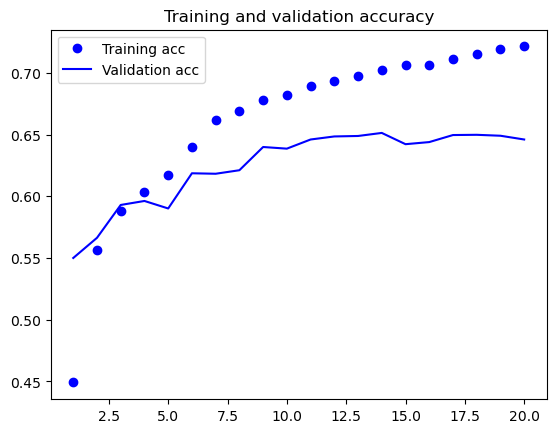

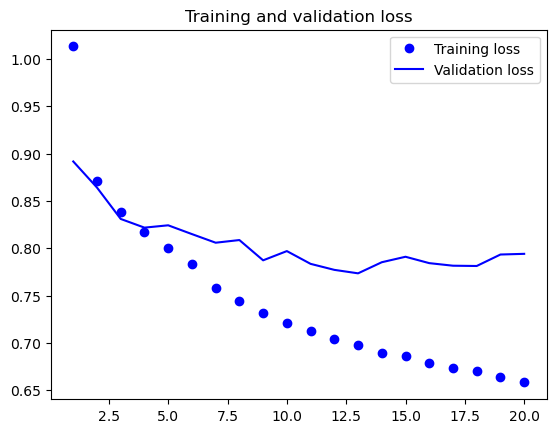

In [84]:
# Plot the Training and Validation Accuracy & Loss Scores

acc = history15vk.history['acc']
val_acc = history15vk.history['val_acc']
loss = history15vk.history['loss']
val_loss = history15vk.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [85]:
# Save the Model
model15vk.save('model15vk.h5')

### Model #16 <a id="model16"></a>

#### recurrent dropout = 0.5
[Back to Model Evaluation](#model16c)

In [101]:
model16vk = Sequential()
model16vk.add(Embedding(vocab_size, 8, input_length=max_length))
model16vk.add(GRU(32, recurrent_dropout=0.05, return_sequences=True))
model16vk.add(GRU(64))
model16vk.add(Dense(32, activation='relu'))
model16vk.add(Dense(3, activation='softmax'))

model16vk.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(learning_rate=0.0005), metrics=['acc'])
model16vk.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 358, 8)            23080     
                                                                 
 gru_28 (GRU)                (None, 358, 32)           4032      
                                                                 
 gru_29 (GRU)                (None, 64)                18816     
                                                                 
 dense_28 (Dense)            (None, 32)                2080      
                                                                 
 dense_29 (Dense)            (None, 3)                 99        
                                                                 
Total params: 48,107
Trainable params: 48,107
Non-trainable params: 0
_________________________________________________________________


In [102]:
history16vk = model16vk.fit(X_train, y_train, 
                          epochs=20, batch_size=25, 
                          validation_split=0.3)

Epoch 1/20
491/491 [==============================] - 248s 468ms/step - loss: 0.9811 - acc: 0.4803 - val_loss: 0.8972 - val_acc: 0.5534
Epoch 2/20
491/491 [==============================] - 211s 431ms/step - loss: 0.8609 - acc: 0.5743 - val_loss: 0.9010 - val_acc: 0.5500
Epoch 3/20
491/491 [==============================] - 233s 475ms/step - loss: 0.8225 - acc: 0.6116 - val_loss: 0.8479 - val_acc: 0.5908
Epoch 4/20
491/491 [==============================] - 298s 608ms/step - loss: 0.7904 - acc: 0.6328 - val_loss: 0.8229 - val_acc: 0.6114
Epoch 5/20
491/491 [==============================] - 308s 629ms/step - loss: 0.7679 - acc: 0.6486 - val_loss: 0.8164 - val_acc: 0.6199
Epoch 6/20
491/491 [==============================] - 269s 549ms/step - loss: 0.7497 - acc: 0.6635 - val_loss: 0.8029 - val_acc: 0.6273
Epoch 7/20
491/491 [==============================] - 361s 735ms/step - loss: 0.7353 - acc: 0.6706 - val_loss: 0.7946 - val_acc: 0.6368
Epoch 8/20
491/491 [============================

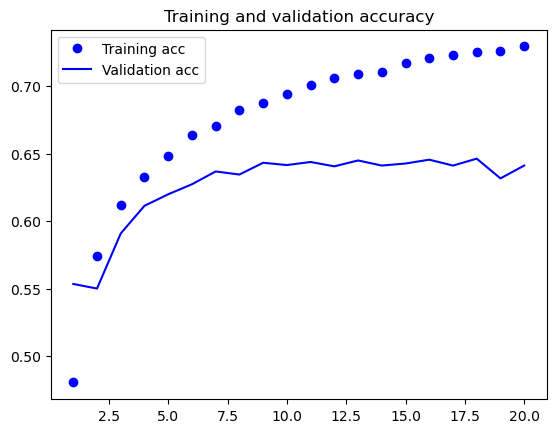

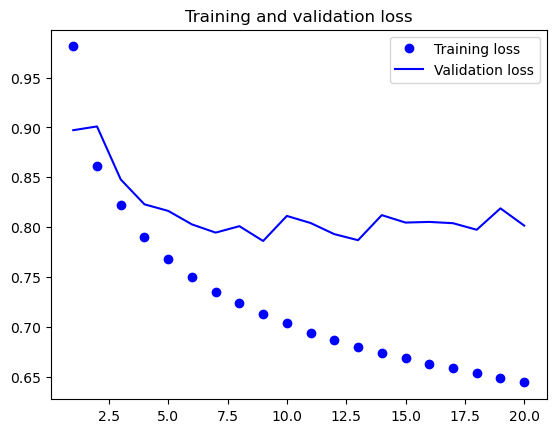

In [103]:
# Plot the Training and Validation Accuracy & Loss Scores

acc = history16vk.history['acc']
val_acc = history16vk.history['val_acc']
loss = history16vk.history['loss']
val_loss = history16vk.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [104]:
# Save the Model
model16vk.save('model16vk.h5')

### Model #17 <a id="model17"></a>

#### L2 regularizers: 0.001
[Back to Model Evaluation](#model17c)

In [106]:
model17vk = Sequential()
model17vk.add(Embedding(vocab_size, 8, input_length=max_length))
model17vk.add(GRU(32, return_sequences=True))
model17vk.add(GRU(64))
model17vk.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model17vk.add(Dense(3, activation='softmax', kernel_regularizer=regularizers.l2(0.001)))

model17vk.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(learning_rate=0.0005), metrics=['acc'])
model17vk.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 358, 8)            23080     
                                                                 
 gru_30 (GRU)                (None, 358, 32)           4032      
                                                                 
 gru_31 (GRU)                (None, 64)                18816     
                                                                 
 dense_30 (Dense)            (None, 32)                2080      
                                                                 
 dense_31 (Dense)            (None, 3)                 99        
                                                                 
Total params: 48,107
Trainable params: 48,107
Non-trainable params: 0
_________________________________________________________________


In [107]:
history17vk = model17vk.fit(X_train, y_train, 
                          epochs=20, batch_size=25, 
                          validation_split=0.3)

Epoch 1/20
491/491 [==============================] - 199s 384ms/step - loss: 1.0315 - acc: 0.4621 - val_loss: 0.8984 - val_acc: 0.5525
Epoch 2/20
491/491 [==============================] - 196s 400ms/step - loss: 0.8872 - acc: 0.5599 - val_loss: 0.8734 - val_acc: 0.5737
Epoch 3/20
491/491 [==============================] - 159s 323ms/step - loss: 0.8508 - acc: 0.5889 - val_loss: 0.8493 - val_acc: 0.5884
Epoch 4/20
491/491 [==============================] - 181s 369ms/step - loss: 0.8242 - acc: 0.6156 - val_loss: 0.8355 - val_acc: 0.6078
Epoch 5/20
491/491 [==============================] - 183s 374ms/step - loss: 0.7937 - acc: 0.6389 - val_loss: 0.8204 - val_acc: 0.6171
Epoch 6/20
491/491 [==============================] - 199s 405ms/step - loss: 0.7740 - acc: 0.6524 - val_loss: 0.8426 - val_acc: 0.6022
Epoch 7/20
491/491 [==============================] - 188s 382ms/step - loss: 0.7596 - acc: 0.6655 - val_loss: 0.8057 - val_acc: 0.6281
Epoch 8/20
491/491 [============================

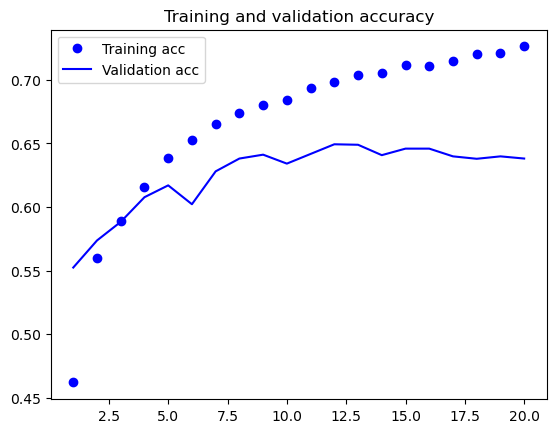

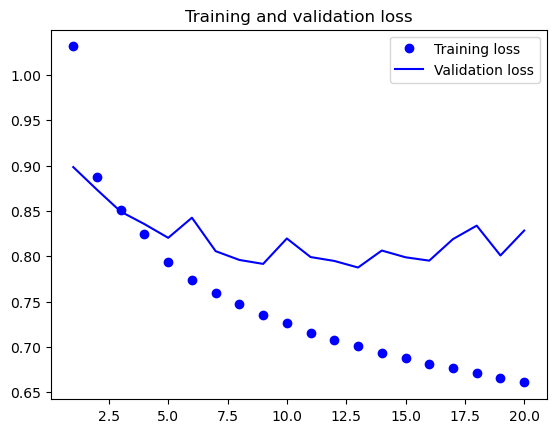

In [108]:
# Plot the Training and Validation Accuracy & Loss Scores

acc = history17vk.history['acc']
val_acc = history17vk.history['val_acc']
loss = history17vk.history['loss']
val_loss = history17vk.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [109]:
# Save the Model
model17vk.save('model17vk.h5')

### Model #18 <a id="model18"></a>

#### L2 regularizers: 0.0001
[Back to Model Evaluation](#model18c)

In [130]:
model18vk = Sequential()
model18vk.add(Embedding(vocab_size, 8, input_length=max_length))
model18vk.add(GRU(32,kernel_regularizer=regularizers.l2(0.0001), return_sequences=True))
model18vk.add(GRU(64, kernel_regularizer=regularizers.l2(0.0001)))
model18vk.add(Dense(32, activation='relu'))
model18vk.add(Dense(3, activation='softmax'))

model18vk.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(learning_rate=0.0005), metrics=['acc'])
model18vk.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, 358, 8)            23080     
                                                                 
 gru_42 (GRU)                (None, 358, 32)           4032      
                                                                 
 gru_43 (GRU)                (None, 64)                18816     
                                                                 
 dense_42 (Dense)            (None, 32)                2080      
                                                                 
 dense_43 (Dense)            (None, 3)                 99        
                                                                 
Total params: 48,107
Trainable params: 48,107
Non-trainable params: 0
_________________________________________________________________


In [131]:
history18vk = model18vk.fit(X_train, y_train, 
                          epochs=20, batch_size=25, 
                          validation_split=0.3)

Epoch 1/20
491/491 [==============================] - 110s 216ms/step - loss: 0.9997 - acc: 0.4681 - val_loss: 0.8995 - val_acc: 0.5429
Epoch 2/20
491/491 [==============================] - 118s 239ms/step - loss: 0.8742 - acc: 0.5590 - val_loss: 0.8574 - val_acc: 0.5720
Epoch 3/20
491/491 [==============================] - 135s 274ms/step - loss: 0.8387 - acc: 0.5930 - val_loss: 0.8417 - val_acc: 0.5859
Epoch 4/20
491/491 [==============================] - 130s 265ms/step - loss: 0.8085 - acc: 0.6221 - val_loss: 0.8334 - val_acc: 0.5933
Epoch 5/20
491/491 [==============================] - 138s 282ms/step - loss: 0.7801 - acc: 0.6412 - val_loss: 0.8325 - val_acc: 0.6144
Epoch 6/20
491/491 [==============================] - 132s 269ms/step - loss: 0.7626 - acc: 0.6547 - val_loss: 0.8236 - val_acc: 0.6129
Epoch 7/20
491/491 [==============================] - 130s 265ms/step - loss: 0.7471 - acc: 0.6675 - val_loss: 0.8039 - val_acc: 0.6296
Epoch 8/20
491/491 [============================

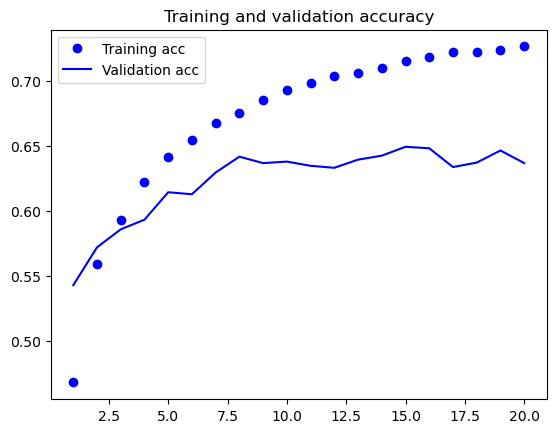

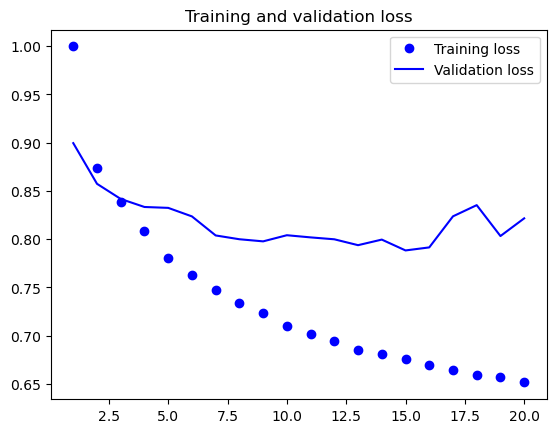

In [132]:
# Plot the Training and Validation Accuracy & Loss Scores

acc = history18vk.history['acc']
val_acc = history18vk.history['val_acc']
loss = history18vk.history['loss']
val_loss = history18vk.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [133]:
# Save the Model
model18vk.save('model18vk.h5')

### Model #19 <a id="model19"></a>

#### L1 regularizers: 0.0001 on dense layer
[Back to Model Evaluation](#model19c)


In [125]:
model19vk = Sequential()
model19vk.add(Embedding(vocab_size, 8, input_length=max_length))
model19vk.add(GRU(32, return_sequences=True))
model19vk.add(GRU(64))
model19vk.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l1(0.0001)))
model19vk.add(Dense(3, activation='softmax', kernel_regularizer=regularizers.l1(0.0001)))

model19vk.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(learning_rate=0.0005), metrics=['acc'])
model19vk.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 358, 8)            23080     
                                                                 
 gru_40 (GRU)                (None, 358, 32)           4032      
                                                                 
 gru_41 (GRU)                (None, 64)                18816     
                                                                 
 dense_40 (Dense)            (None, 32)                2080      
                                                                 
 dense_41 (Dense)            (None, 3)                 99        
                                                                 
Total params: 48,107
Trainable params: 48,107
Non-trainable params: 0
_________________________________________________________________


In [126]:
history19vk = model19vk.fit(X_train, y_train, 
                          epochs=20, batch_size=25, 
                          validation_split=0.3)

Epoch 1/20
491/491 [==============================] - 158s 309ms/step - loss: 1.0363 - acc: 0.4491 - val_loss: 0.9101 - val_acc: 0.5488
Epoch 2/20
491/491 [==============================] - 140s 286ms/step - loss: 0.8907 - acc: 0.5564 - val_loss: 0.8668 - val_acc: 0.5741
Epoch 3/20
491/491 [==============================] - 138s 282ms/step - loss: 0.8539 - acc: 0.5835 - val_loss: 0.8476 - val_acc: 0.5870
Epoch 4/20
491/491 [==============================] - 160s 326ms/step - loss: 0.8299 - acc: 0.6092 - val_loss: 0.8937 - val_acc: 0.5796
Epoch 5/20
491/491 [==============================] - 108s 220ms/step - loss: 0.8000 - acc: 0.6348 - val_loss: 0.8213 - val_acc: 0.6176
Epoch 6/20
491/491 [==============================] - 113s 230ms/step - loss: 0.7762 - acc: 0.6512 - val_loss: 0.8209 - val_acc: 0.6237
Epoch 7/20
491/491 [==============================] - 124s 252ms/step - loss: 0.7606 - acc: 0.6635 - val_loss: 0.8086 - val_acc: 0.6378
Epoch 8/20
491/491 [============================

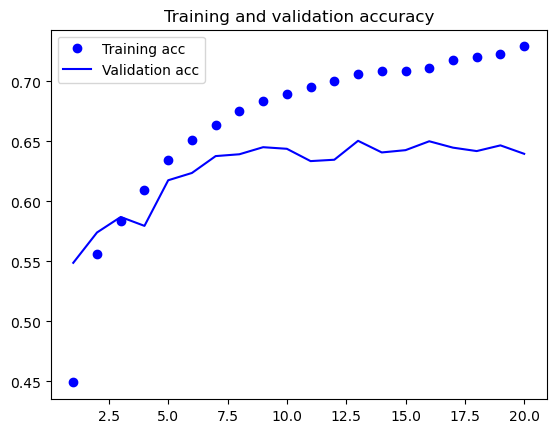

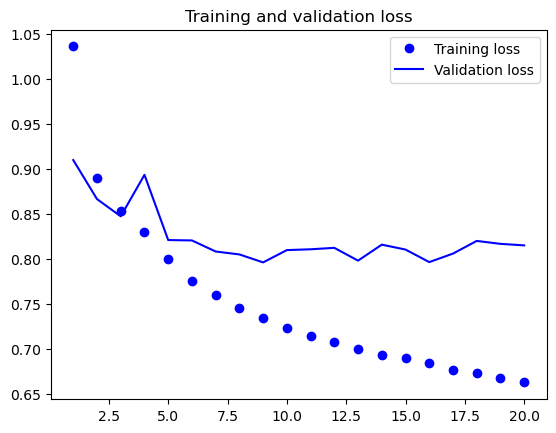

In [127]:
# Plot the Training and Validation Accuracy & Loss Scores

acc = history19vk.history['acc']
val_acc = history19vk.history['val_acc']
loss = history19vk.history['loss']
val_loss = history19vk.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [128]:
# Save the Model
model19vk.save('model19vk.h5')

### Model #20 <a id="model20"></a>

####  L1 regularizers: 0.0001 on GRU layer
[Back to Model Evaluation](#model20c)

In [137]:
model20vk = Sequential()
model20vk.add(Embedding(vocab_size, 8, input_length=max_length))
model20vk.add(GRU(32,kernel_regularizer=regularizers.l1(0.0001), return_sequences=True))
model20vk.add(GRU(64,kernel_regularizer=regularizers.l1(0.0001)))
model20vk.add(Dense(32, activation='relu'))
model20vk.add(Dense(3, activation='softmax'))

model20vk.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(learning_rate=0.0005), metrics=['acc'])
model20vk.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 358, 8)            23080     
                                                                 
 gru_46 (GRU)                (None, 358, 32)           4032      
                                                                 
 gru_47 (GRU)                (None, 64)                18816     
                                                                 
 dense_46 (Dense)            (None, 32)                2080      
                                                                 
 dense_47 (Dense)            (None, 3)                 99        
                                                                 
Total params: 48,107
Trainable params: 48,107
Non-trainable params: 0
_________________________________________________________________


In [138]:
history20vk = model20vk.fit(X_train, y_train, 
                          epochs=20, batch_size=25, 
                          validation_split=0.3)

Epoch 1/20
491/491 [==============================] - 139s 276ms/step - loss: 1.0396 - acc: 0.4692 - val_loss: 0.9239 - val_acc: 0.5570
Epoch 2/20
491/491 [==============================] - 150s 305ms/step - loss: 0.8896 - acc: 0.5638 - val_loss: 0.8746 - val_acc: 0.5701
Epoch 3/20
491/491 [==============================] - 135s 276ms/step - loss: 0.8463 - acc: 0.5941 - val_loss: 0.8486 - val_acc: 0.5796
Epoch 4/20
491/491 [==============================] - 167s 341ms/step - loss: 0.8248 - acc: 0.6123 - val_loss: 0.8449 - val_acc: 0.5870
Epoch 5/20
491/491 [==============================] - 134s 273ms/step - loss: 0.8082 - acc: 0.6225 - val_loss: 0.8619 - val_acc: 0.5773
Epoch 6/20
491/491 [==============================] - 151s 307ms/step - loss: 0.7997 - acc: 0.6314 - val_loss: 0.8399 - val_acc: 0.6051
Epoch 7/20
491/491 [==============================] - 142s 289ms/step - loss: 0.7811 - acc: 0.6497 - val_loss: 0.8378 - val_acc: 0.6121
Epoch 8/20
491/491 [============================

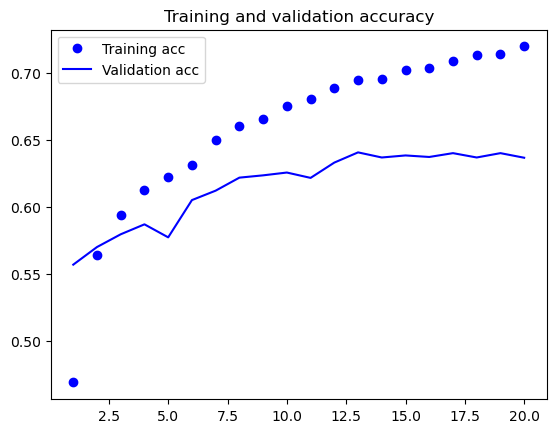

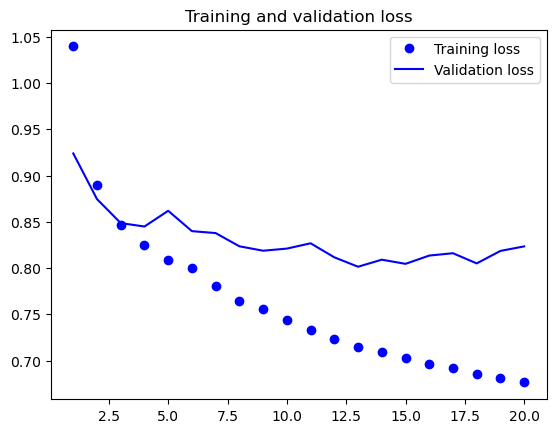

In [139]:
# Plot the Training and Validation Accuracy & Loss Scores

acc = history20vk.history['acc']
val_acc = history20vk.history['val_acc']
loss = history20vk.history['loss']
val_loss = history20vk.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [140]:
# Save the Model
model20vk.save('model20vk.h5')

### Model #21 <a id="model21"></a>

#### Optimizer: Adam
[Back to Model Evaluation](#model21c)

In [143]:
model21vk = Sequential()
model21vk.add(Embedding(vocab_size, 8, input_length=max_length))
model21vk.add(GRU(32, return_sequences=True))
model21vk.add(GRU(64))
model21vk.add(Dense(32, activation='relu'))
model21vk.add(Dense(3, activation='softmax'))

model21vk.compile(loss='categorical_crossentropy', 
                  optimizer=optimizers.Adam(learning_rate=0.0005), metrics=['acc'])
model21vk.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_25 (Embedding)    (None, 358, 8)            23080     
                                                                 
 gru_50 (GRU)                (None, 358, 32)           4032      
                                                                 
 gru_51 (GRU)                (None, 64)                18816     
                                                                 
 dense_50 (Dense)            (None, 32)                2080      
                                                                 
 dense_51 (Dense)            (None, 3)                 99        
                                                                 
Total params: 48,107
Trainable params: 48,107
Non-trainable params: 0
_________________________________________________________________


In [145]:
history21vk = model21vk.fit(X_train, y_train, 
                          epochs=20, batch_size=25, 
                          validation_split=0.3)

Epoch 1/20
491/491 [==============================] - 100s 197ms/step - loss: 0.9575 - acc: 0.4990 - val_loss: 0.8812 - val_acc: 0.5526
Epoch 2/20
491/491 [==============================] - 99s 201ms/step - loss: 0.8302 - acc: 0.5910 - val_loss: 0.8348 - val_acc: 0.5906
Epoch 3/20
491/491 [==============================] - 98s 199ms/step - loss: 0.7887 - acc: 0.6231 - val_loss: 0.8288 - val_acc: 0.6011
Epoch 4/20
491/491 [==============================] - 98s 199ms/step - loss: 0.7453 - acc: 0.6552 - val_loss: 0.8475 - val_acc: 0.6106
Epoch 5/20
491/491 [==============================] - 96s 196ms/step - loss: 0.7079 - acc: 0.6820 - val_loss: 0.8259 - val_acc: 0.6216
Epoch 6/20
491/491 [==============================] - 97s 197ms/step - loss: 0.6840 - acc: 0.6996 - val_loss: 0.8899 - val_acc: 0.6057
Epoch 7/20
491/491 [==============================] - 98s 199ms/step - loss: 0.6611 - acc: 0.7136 - val_loss: 0.8176 - val_acc: 0.6336
Epoch 8/20
491/491 [==============================] - 

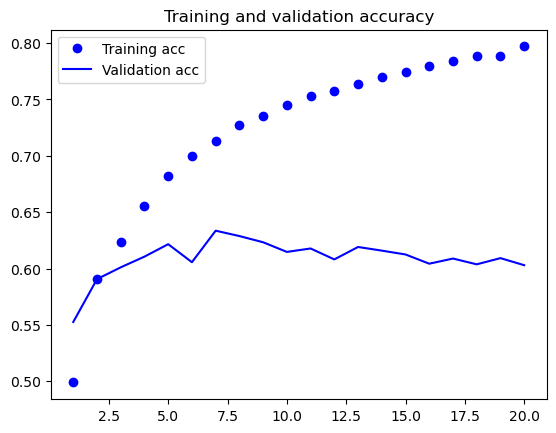

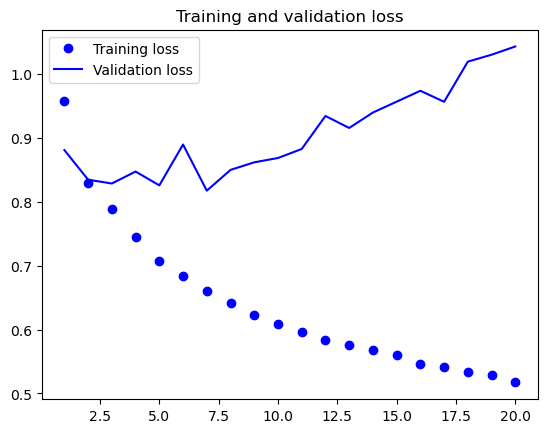

In [146]:
# Plot the Training and Validation Accuracy & Loss Scores

acc = history21vk.history['acc']
val_acc = history21vk.history['val_acc']
loss = history21vk.history['loss']
val_loss = history21vk.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [147]:
# Save the Model
model21vk.save('model21vk.h5')

### Model #22 <a id="model22"></a>

#### Optimizer: SGD
[Back to Model Evaluation](#model22c)

In [181]:
model22vk = Sequential()
model22vk.add(Embedding(vocab_size, 8, input_length=max_length))
model22vk.add(GRU(32, return_sequences=True))
model22vk.add(GRU(64))
model22vk.add(Dense(32, activation='relu'))
model22vk.add(Dense(3, activation='softmax'))

model22vk.compile(loss='categorical_crossentropy', 
                  optimizer=optimizers.SGD(learning_rate=0.0005), metrics=['acc'])
model22vk.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_32 (Embedding)    (None, 358, 8)            23080     
                                                                 
 gru_64 (GRU)                (None, 358, 32)           4032      
                                                                 
 gru_65 (GRU)                (None, 64)                18816     
                                                                 
 dense_64 (Dense)            (None, 32)                2080      
                                                                 
 dense_65 (Dense)            (None, 3)                 99        
                                                                 
Total params: 48,107
Trainable params: 48,107
Non-trainable params: 0
_________________________________________________________________


In [149]:
history22vk = model22vk.fit(X_train, y_train, 
                          epochs=20, batch_size=25, 
                          validation_split=0.3)

Epoch 1/20
491/491 [==============================] - 99s 197ms/step - loss: 1.0983 - acc: 0.3658 - val_loss: 1.0982 - val_acc: 0.3620
Epoch 2/20
491/491 [==============================] - 99s 202ms/step - loss: 1.0981 - acc: 0.3560 - val_loss: 1.0982 - val_acc: 0.3569
Epoch 3/20
491/491 [==============================] - 97s 197ms/step - loss: 1.0981 - acc: 0.3564 - val_loss: 1.0982 - val_acc: 0.3425
Epoch 4/20
491/491 [==============================] - 98s 199ms/step - loss: 1.0980 - acc: 0.3530 - val_loss: 1.0982 - val_acc: 0.3312
Epoch 5/20
491/491 [==============================] - 98s 199ms/step - loss: 1.0980 - acc: 0.3449 - val_loss: 1.0981 - val_acc: 0.3274
Epoch 6/20
491/491 [==============================] - 98s 200ms/step - loss: 1.0980 - acc: 0.3390 - val_loss: 1.0981 - val_acc: 0.3273
Epoch 7/20
491/491 [==============================] - 99s 203ms/step - loss: 1.0979 - acc: 0.3410 - val_loss: 1.0981 - val_acc: 0.3261
Epoch 8/20
491/491 [==============================] - 9

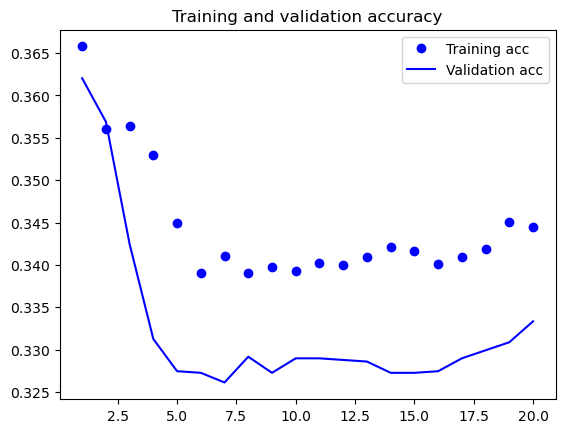

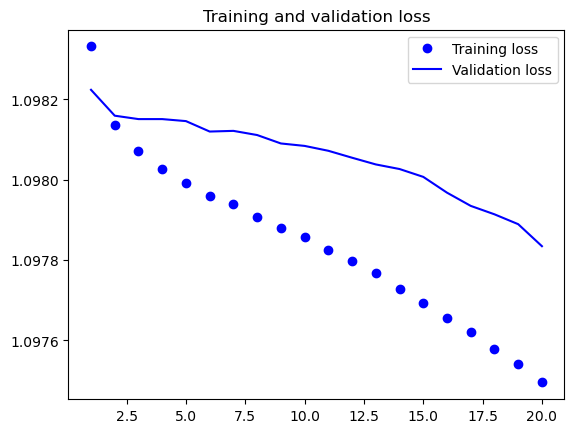

In [150]:
# Plot the Training and Validation Accuracy & Loss Scores

acc = history22vk.history['acc']
val_acc = history22vk.history['val_acc']
loss = history22vk.history['loss']
val_loss = history22vk.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [153]:
# Save the Model
model22vk.save('model22vk.h5')

### Model #23 <a id="model23"></a>

#### Embedding dimension: 50
[Back to Model Evaluation](#model23c)

In [182]:
model23vk = Sequential()
model23vk.add(Embedding(vocab_size, 50, input_length=max_length))
model23vk.add(GRU(32, return_sequences=True))
model23vk.add(GRU(64))
model23vk.add(Dense(32, activation='relu'))
model23vk.add(Dense(3, activation='softmax'))

model23vk.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(learning_rate=0.0005), metrics=['acc'])
model23vk.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_33 (Embedding)    (None, 358, 50)           144250    
                                                                 
 gru_66 (GRU)                (None, 358, 32)           8064      
                                                                 
 gru_67 (GRU)                (None, 64)                18816     
                                                                 
 dense_66 (Dense)            (None, 32)                2080      
                                                                 
 dense_67 (Dense)            (None, 3)                 99        
                                                                 
Total params: 173,309
Trainable params: 173,309
Non-trainable params: 0
_________________________________________________________________


In [158]:
history23vk = model23vk.fit(X_train, y_train, 
                          epochs=20, batch_size=25, 
                          validation_split=0.3)

Epoch 1/20
491/491 [==============================] - 119s 229ms/step - loss: 0.9471 - acc: 0.5056 - val_loss: 0.8677 - val_acc: 0.5694
Epoch 2/20
491/491 [==============================] - 103s 210ms/step - loss: 0.8303 - acc: 0.5999 - val_loss: 0.8094 - val_acc: 0.6182
Epoch 3/20
491/491 [==============================] - 99s 201ms/step - loss: 0.7775 - acc: 0.6411 - val_loss: 0.8061 - val_acc: 0.6268
Epoch 4/20
491/491 [==============================] - 100s 205ms/step - loss: 0.7501 - acc: 0.6635 - val_loss: 0.8345 - val_acc: 0.6152
Epoch 5/20
491/491 [==============================] - 100s 203ms/step - loss: 0.7270 - acc: 0.6771 - val_loss: 0.7826 - val_acc: 0.6433
Epoch 6/20
491/491 [==============================] - 98s 200ms/step - loss: 0.7101 - acc: 0.6894 - val_loss: 0.7984 - val_acc: 0.6330
Epoch 7/20
491/491 [==============================] - 101s 205ms/step - loss: 0.6967 - acc: 0.7015 - val_loss: 0.7841 - val_acc: 0.6429
Epoch 8/20
491/491 [==============================

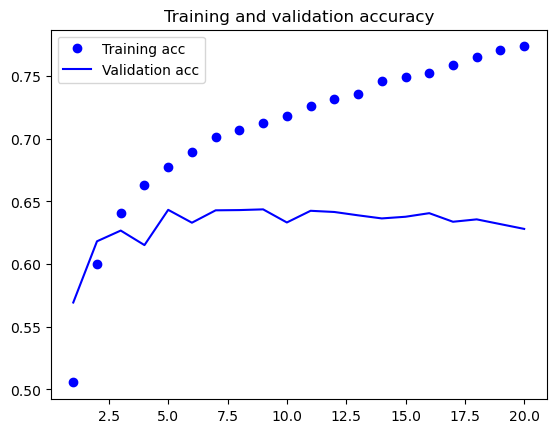

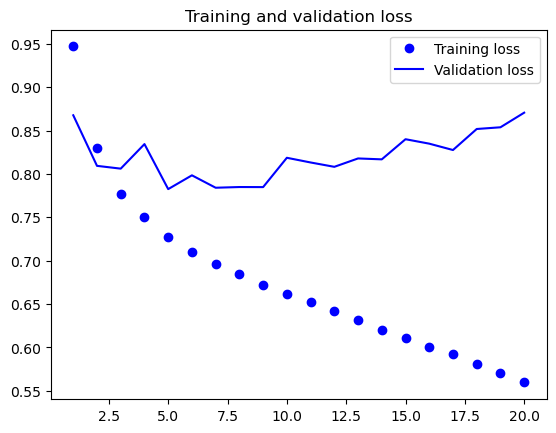

In [159]:
# Plot the Training and Validation Accuracy & Loss Scores

acc = history23vk.history['acc']
val_acc = history23vk.history['val_acc']
loss = history23vk.history['loss']
val_loss = history23vk.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [162]:
# Save the Model
model23vk.save('model23vk.h5')

### Model #24 <a id="model24"></a>

#### Embedding dimension: 25
[Back to Model Evaluation](#model24c)

In [176]:
model24vk = Sequential()
model24vk.add(Embedding(vocab_size, 25, input_length=max_length))
model24vk.add(GRU(32, return_sequences=True))
model24vk.add(GRU(64))
model24vk.add(Dense(32, activation='relu'))
model24vk.add(Dense(3, activation='softmax'))

model24vk.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(learning_rate=0.0005), metrics=['acc'])
model24vk.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_31 (Embedding)    (None, 358, 25)           72125     
                                                                 
 gru_62 (GRU)                (None, 358, 32)           5664      
                                                                 
 gru_63 (GRU)                (None, 64)                18816     
                                                                 
 dense_62 (Dense)            (None, 32)                2080      
                                                                 
 dense_63 (Dense)            (None, 3)                 99        
                                                                 
Total params: 98,784
Trainable params: 98,784
Non-trainable params: 0
_________________________________________________________________


In [177]:
history24vk = model24vk.fit(X_train, y_train, 
                        epochs=20, batch_size=25, 
                        validation_split=0.3)

Epoch 1/20
491/491 [==============================] - 113s 224ms/step - loss: 0.9576 - acc: 0.4963 - val_loss: 0.8551 - val_acc: 0.5703
Epoch 2/20
491/491 [==============================] - 115s 234ms/step - loss: 0.8469 - acc: 0.5798 - val_loss: 0.8314 - val_acc: 0.5891
Epoch 3/20
491/491 [==============================] - 110s 225ms/step - loss: 0.8114 - acc: 0.6112 - val_loss: 0.8208 - val_acc: 0.6057
Epoch 4/20
491/491 [==============================] - 119s 243ms/step - loss: 0.7751 - acc: 0.6459 - val_loss: 0.8051 - val_acc: 0.6205
Epoch 5/20
491/491 [==============================] - 118s 241ms/step - loss: 0.7527 - acc: 0.6585 - val_loss: 0.8020 - val_acc: 0.6277
Epoch 6/20
491/491 [==============================] - 124s 254ms/step - loss: 0.7363 - acc: 0.6737 - val_loss: 0.8014 - val_acc: 0.6321
Epoch 7/20
491/491 [==============================] - 137s 280ms/step - loss: 0.7197 - acc: 0.6867 - val_loss: 0.7903 - val_acc: 0.6342
Epoch 8/20
491/491 [============================

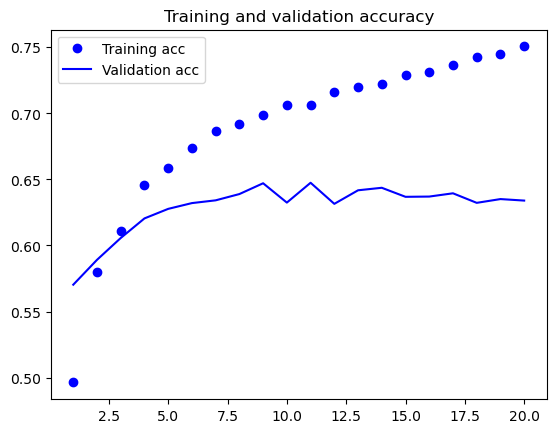

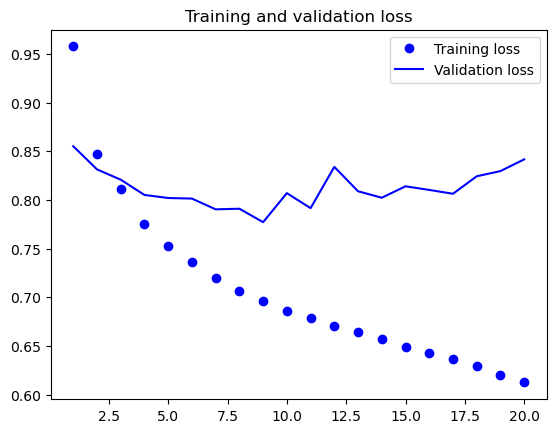

In [178]:
# Plot the Training and Validation Accuracy & Loss Scores

acc = history24vk.history['acc']
val_acc = history24vk.history['val_acc']
loss = history24vk.history['loss']
val_loss = history24vk.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [179]:
# Save the Model
model24vk.save('model24vk.h5')

### Model #25<a id="model25"></a>

#### Batch size:32
[Back to Model Evaluation](#model25c)

In [202]:
model25vk = Sequential()
model25vk.add(Embedding(vocab_size, 8, input_length=max_length))
model25vk.add(GRU(32, return_sequences=True))
model25vk.add(GRU(64))
model25vk.add(Dense(32, activation='relu'))
model25vk.add(Dense(3, activation='softmax'))

model25vk.compile(loss='categorical_crossentropy', 
                  optimizer=optimizers.RMSprop(learning_rate=0.0005), metrics=['acc'])
model25vk.summary()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_39 (Embedding)    (None, 358, 25)           72125     
                                                                 
 gru_78 (GRU)                (None, 358, 32)           5664      
                                                                 
 gru_79 (GRU)                (None, 64)                18816     
                                                                 
 dense_78 (Dense)            (None, 32)                2080      
                                                                 
 dense_79 (Dense)            (None, 3)                 99        
                                                                 
Total params: 98,784
Trainable params: 98,784
Non-trainable params: 0
_________________________________________________________________


In [204]:
history25vk = model25vk.fit(X_train, y_train, 
                          epochs=20, batch_size=32, 
                          validation_split=0.3)

Epoch 1/20
384/384 [==============================] - 140s 350ms/step - loss: 0.9747 - acc: 0.4885 - val_loss: 0.8628 - val_acc: 0.5694
Epoch 2/20
384/384 [==============================] - 136s 353ms/step - loss: 0.8519 - acc: 0.5768 - val_loss: 0.8312 - val_acc: 0.5897
Epoch 3/20
384/384 [==============================] - 165s 430ms/step - loss: 0.8089 - acc: 0.6211 - val_loss: 0.8112 - val_acc: 0.6169
Epoch 4/20
384/384 [==============================] - 152s 396ms/step - loss: 0.7722 - acc: 0.6490 - val_loss: 0.8022 - val_acc: 0.6340
Epoch 5/20
384/384 [==============================] - 165s 429ms/step - loss: 0.7482 - acc: 0.6613 - val_loss: 0.8000 - val_acc: 0.6292
Epoch 6/20
384/384 [==============================] - 175s 455ms/step - loss: 0.7293 - acc: 0.6784 - val_loss: 0.8054 - val_acc: 0.6376
Epoch 7/20
384/384 [==============================] - 182s 474ms/step - loss: 0.7140 - acc: 0.6890 - val_loss: 0.7977 - val_acc: 0.6389
Epoch 8/20
384/384 [============================

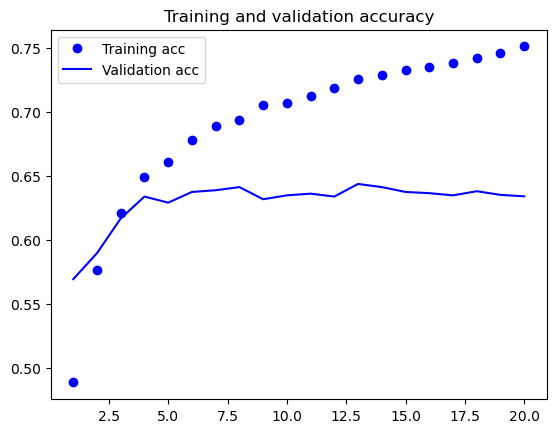

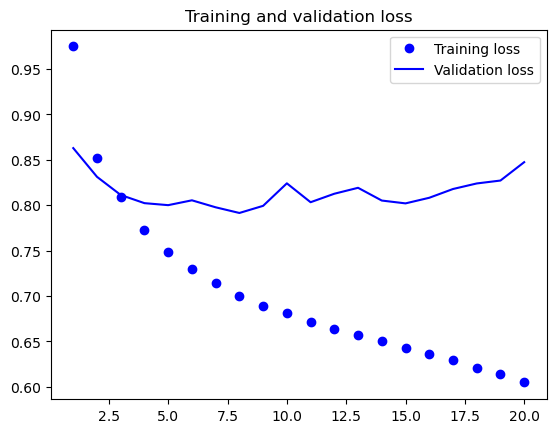

In [205]:
# Plot the Training and Validation Accuracy & Loss Scores

acc = history25vk.history['acc']
val_acc = history25vk.history['val_acc']
loss = history25vk.history['loss']
val_loss = history25vk.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [206]:
# Save the Model
model25vk.save('model25vk.h5')

### Model #26 <a id="model26"></a>

#### Batch size: 64
[Back to Model Evaluation](#model26c)

In [208]:
model26vk = Sequential()
model26vk.add(Embedding(vocab_size, 8, input_length=max_length))
model26vk.add(GRU(32, return_sequences=True))
model26vk.add(GRU(64))
model26vk.add(Dense(32, activation='relu'))
model26vk.add(Dense(3, activation='softmax'))

model26vk.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(learning_rate=0.0005), metrics=['acc'])
model26vk.summary()

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_40 (Embedding)    (None, 358, 8)            23080     
                                                                 
 gru_80 (GRU)                (None, 358, 32)           4032      
                                                                 
 gru_81 (GRU)                (None, 64)                18816     
                                                                 
 dense_80 (Dense)            (None, 32)                2080      
                                                                 
 dense_81 (Dense)            (None, 3)                 99        
                                                                 
Total params: 48,107
Trainable params: 48,107
Non-trainable params: 0
_________________________________________________________________


In [209]:
history26vk = model26vk.fit(X_train, y_train, 
                          epochs=20, batch_size=64, 
                          validation_split=0.3)

Epoch 1/20
192/192 [==============================] - 176s 865ms/step - loss: 1.0494 - acc: 0.4278 - val_loss: 0.9512 - val_acc: 0.5103
Epoch 2/20
192/192 [==============================] - 186s 970ms/step - loss: 0.8528 - acc: 0.5747 - val_loss: 0.8468 - val_acc: 0.5764
Epoch 4/20
192/192 [==============================] - 173s 902ms/step - loss: 0.8205 - acc: 0.6064 - val_loss: 0.8435 - val_acc: 0.5933
Epoch 5/20
192/192 [==============================] - 173s 903ms/step - loss: 0.7956 - acc: 0.6275 - val_loss: 0.8251 - val_acc: 0.6104
Epoch 6/20
192/192 [==============================] - 185s 963ms/step - loss: 0.7726 - acc: 0.6456 - val_loss: 0.8184 - val_acc: 0.6136
Epoch 7/20
192/192 [==============================] - 181s 946ms/step - loss: 0.7551 - acc: 0.6578 - val_loss: 0.8154 - val_acc: 0.6161
Epoch 8/20
192/192 [==============================] - 199s 1s/step - loss: 0.7445 - acc: 0.6624 - val_loss: 0.8095 - val_acc: 0.6192
Epoch 9/20
192/192 [==============================]

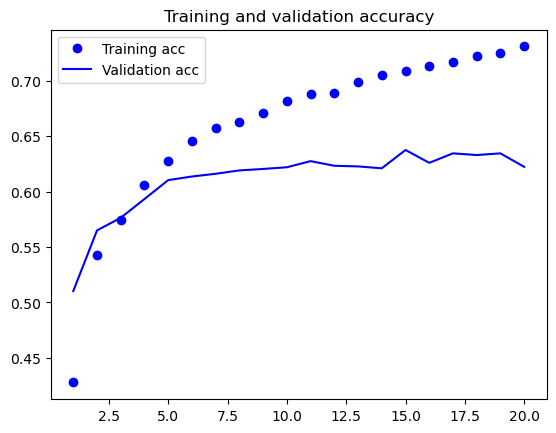

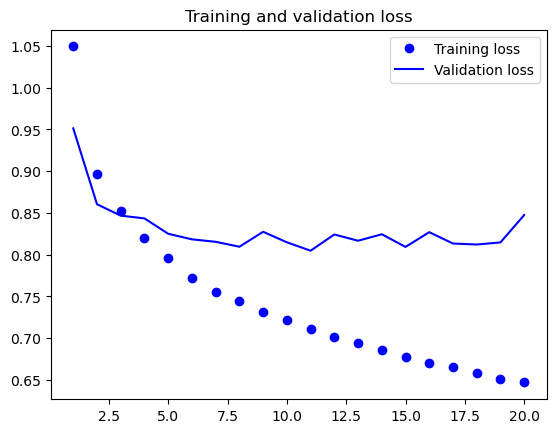

In [210]:
# Plot the Training and Validation Accuracy & Loss Scores

acc = history26vk.history['acc']
val_acc = history26vk.history['val_acc']
loss = history26vk.history['loss']
val_loss = history26vk.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [211]:
# Save the Model
model26vk.save('model26vk.h5')

### Model #27 <a id="model27"></a>

#### MaxPooling1D (Size =2)
[Back to Model Evaluation](#model27c)

In [297]:
model27vk = Sequential()
model27vk.add(Embedding(vocab_size, 50, input_length=max_length))
model27vk.add(GRU(32, return_sequences=True))
model27vk.add(MaxPooling1D(pool_size=2))
model27vk.add(GRU(64))
model27vk.add(Dense(32, activation='relu'))
model27vk.add(Dense(3, activation='softmax'))

model27vk.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(learning_rate=0.0005), metrics=['acc'])
model27vk.summary()


Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_59 (Embedding)    (None, 358, 50)           144250    
                                                                 
 gru_116 (GRU)               (None, 358, 32)           8064      
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 179, 32)          0         
 g1D)                                                            
                                                                 
 gru_117 (GRU)               (None, 64)                18816     
                                                                 
 dense_110 (Dense)           (None, 32)                2080      
                                                                 
 dense_111 (Dense)           (None, 3)                 99        
                                                     

In [231]:
history27vk = model27vk.fit(X_train, y_train, 
                          epochs=20, batch_size=25, 
                          validation_split=0.3)

Epoch 1/20
491/491 [==============================] - 128s 249ms/step - loss: 0.9499 - acc: 0.5094 - val_loss: 0.9016 - val_acc: 0.5410
Epoch 2/20
491/491 [==============================] - 123s 250ms/step - loss: 0.8358 - acc: 0.5949 - val_loss: 0.8180 - val_acc: 0.6076
Epoch 3/20
491/491 [==============================] - 119s 242ms/step - loss: 0.7772 - acc: 0.6451 - val_loss: 0.8006 - val_acc: 0.6266
Epoch 4/20
491/491 [==============================] - 113s 231ms/step - loss: 0.7465 - acc: 0.6647 - val_loss: 0.8036 - val_acc: 0.6250
Epoch 5/20
491/491 [==============================] - 122s 248ms/step - loss: 0.7231 - acc: 0.6802 - val_loss: 0.7819 - val_acc: 0.6454
Epoch 6/20
491/491 [==============================] - 116s 236ms/step - loss: 0.7056 - acc: 0.6899 - val_loss: 0.8166 - val_acc: 0.6250
Epoch 7/20
491/491 [==============================] - 109s 222ms/step - loss: 0.6948 - acc: 0.7012 - val_loss: 0.8040 - val_acc: 0.6355
Epoch 8/20
491/491 [============================

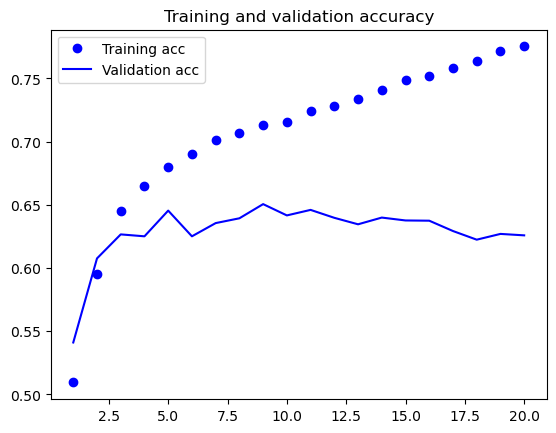

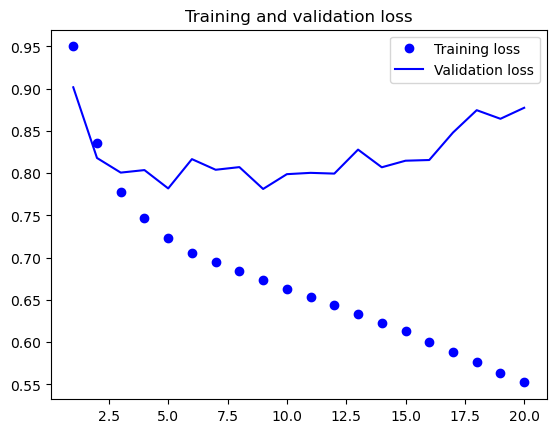

In [232]:
# Plot the Training and Validation Accuracy & Loss Scores

acc = history27vk.history['acc']
val_acc = history27vk.history['val_acc']
loss = history27vk.history['loss']
val_loss = history27vk.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [233]:
# Save the Model
model27vk.save('model27vk.h5')

### Model #28 <a id="model28"></a>

#### Pre-train word embeddings dimension: 50
[Back to Model Evaluation](#model28c)

In [241]:
glove_dir = 'C:\\Users\\xinle\\OneDrive - Ngee Ann Polytechnic\\NP\\2.2\\DL\\week 7'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.50d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400001 word vectors.


In [242]:
embedding_dim = 50
word_index = tokenizer.word_index

embedding_matrix50 = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < vocab_size:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix50[i] = embedding_vector

In [243]:
model28vk = Sequential()
model28vk.add(Embedding(vocab_size, 50, input_length=max_length))
model28vk.add(GRU(32, return_sequences=True))
model28vk.add(MaxPooling1D(pool_size=2))
model28vk.add(GRU(64))
model28vk.add(Dense(32, activation='relu'))
model28vk.add(Dense(3, activation='softmax'))

model28vk.summary()

Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_49 (Embedding)    (None, 358, 50)           144250    
                                                                 
 gru_96 (GRU)                (None, 358, 32)           8064      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 179, 32)          0         
 1D)                                                             
                                                                 
 gru_97 (GRU)                (None, 64)                18816     
                                                                 
 dense_92 (Dense)            (None, 32)                2080      
                                                                 
 dense_93 (Dense)            (None, 3)                 99        
                                                     

In [244]:
model28vk.layers[0].set_weights([embedding_matrix50])
model28vk.layers[0].trainable = False
model28vk.summary()

Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_49 (Embedding)    (None, 358, 50)           144250    
                                                                 
 gru_96 (GRU)                (None, 358, 32)           8064      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 179, 32)          0         
 1D)                                                             
                                                                 
 gru_97 (GRU)                (None, 64)                18816     
                                                                 
 dense_92 (Dense)            (None, 32)                2080      
                                                                 
 dense_93 (Dense)            (None, 3)                 99        
                                                     

In [245]:
model28vk.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(learning_rate=0.0005), metrics=['acc'])

history28vk = model28vk.fit(X_train, y_train, 
                          epochs=15, batch_size=25, 
                          validation_split=0.3)

Epoch 1/15
491/491 [==============================] - 104s 199ms/step - loss: 0.9765 - acc: 0.4919 - val_loss: 0.8942 - val_acc: 0.5656
Epoch 2/15
491/491 [==============================] - 99s 202ms/step - loss: 0.8759 - acc: 0.5691 - val_loss: 0.8556 - val_acc: 0.5777
Epoch 3/15
491/491 [==============================] - 97s 197ms/step - loss: 0.8464 - acc: 0.5962 - val_loss: 0.8343 - val_acc: 0.5937
Epoch 4/15
491/491 [==============================] - 115s 233ms/step - loss: 0.8287 - acc: 0.6067 - val_loss: 0.8171 - val_acc: 0.6076
Epoch 5/15
491/491 [==============================] - 110s 224ms/step - loss: 0.8170 - acc: 0.6144 - val_loss: 0.8145 - val_acc: 0.6108
Epoch 6/15
491/491 [==============================] - 113s 231ms/step - loss: 0.8055 - acc: 0.6214 - val_loss: 0.8133 - val_acc: 0.6146
Epoch 7/15
491/491 [==============================] - 109s 223ms/step - loss: 0.7943 - acc: 0.6294 - val_loss: 0.8041 - val_acc: 0.6192
Epoch 8/15
491/491 [==============================

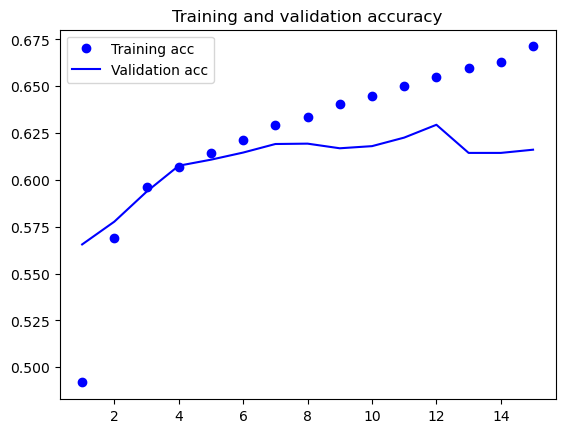

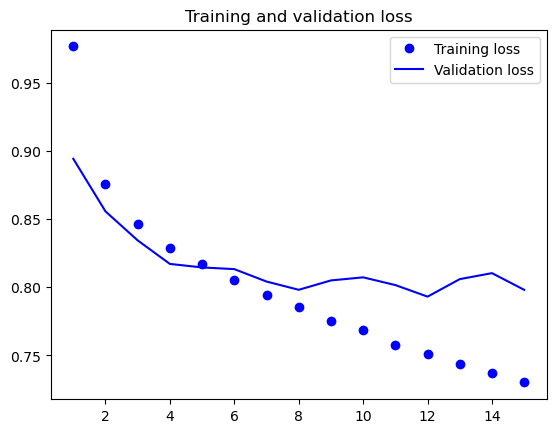

In [246]:
# Plot the Training and Validation Accuracy & Loss Scores

acc = history28vk.history['acc']
val_acc = history28vk.history['val_acc']
loss = history28vk.history['loss']
val_loss = history28vk.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [247]:
# Save the Model
model28vk.save('model28vk.h5')

### Model #29 <a id="model29"></a>

#### Pre-train word embeddings dimension: 100
[Back to Model Evaluation](#model29c)

In [29]:
glove_dir = 'C:\\Users\\xinle\\OneDrive - Ngee Ann Polytechnic\\NP\\2.2\\DL\\week 7'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400001 word vectors.


In [30]:
embedding_dim = 100
word_index = tokenizer.word_index

embedding_matrix100 = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < vocab_size:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix100[i] = embedding_vector

In [251]:
model29vk = Sequential()
model29vk.add(Embedding(vocab_size, 100, input_length=max_length))
model29vk.add(GRU(32, return_sequences=True))
model29vk.add(MaxPooling1D(pool_size=2))
model29vk.add(GRU(64))
model29vk.add(Dense(32, activation='relu'))
model29vk.add(Dense(3, activation='softmax'))

model29vk.summary()

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_50 (Embedding)    (None, 358, 100)          288500    
                                                                 
 gru_98 (GRU)                (None, 358, 32)           12864     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 179, 32)          0         
 1D)                                                             
                                                                 
 gru_99 (GRU)                (None, 64)                18816     
                                                                 
 dense_94 (Dense)            (None, 32)                2080      
                                                                 
 dense_95 (Dense)            (None, 3)                 99        
                                                     

In [252]:
model29vk.layers[0].set_weights([embedding_matrix100])
model29vk.layers[0].trainable = False
model29vk.summary()

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_50 (Embedding)    (None, 358, 100)          288500    
                                                                 
 gru_98 (GRU)                (None, 358, 32)           12864     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 179, 32)          0         
 1D)                                                             
                                                                 
 gru_99 (GRU)                (None, 64)                18816     
                                                                 
 dense_94 (Dense)            (None, 32)                2080      
                                                                 
 dense_95 (Dense)            (None, 3)                 99        
                                                     

In [253]:
model29vk.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(learning_rate=0.0005), metrics=['acc'])

history29vk = model29vk.fit(X_train, y_train, 
                          epochs=15, batch_size=25, 
                          validation_split=0.3)

Epoch 1/15
491/491 [==============================] - 148s 291ms/step - loss: 0.9529 - acc: 0.5099 - val_loss: 0.8759 - val_acc: 0.5654
Epoch 2/15
491/491 [==============================] - 128s 260ms/step - loss: 0.8577 - acc: 0.5851 - val_loss: 0.8393 - val_acc: 0.5865
Epoch 3/15
491/491 [==============================] - 97s 198ms/step - loss: 0.8254 - acc: 0.6059 - val_loss: 0.8567 - val_acc: 0.5844
Epoch 4/15
491/491 [==============================] - 93s 189ms/step - loss: 0.8091 - acc: 0.6201 - val_loss: 0.8121 - val_acc: 0.6152
Epoch 5/15
491/491 [==============================] - 107s 218ms/step - loss: 0.7908 - acc: 0.6299 - val_loss: 0.8111 - val_acc: 0.6119
Epoch 6/15
491/491 [==============================] - 116s 236ms/step - loss: 0.7777 - acc: 0.6367 - val_loss: 0.8026 - val_acc: 0.6146
Epoch 7/15
491/491 [==============================] - 141s 287ms/step - loss: 0.7653 - acc: 0.6465 - val_loss: 0.8065 - val_acc: 0.6102
Epoch 8/15
491/491 [==============================

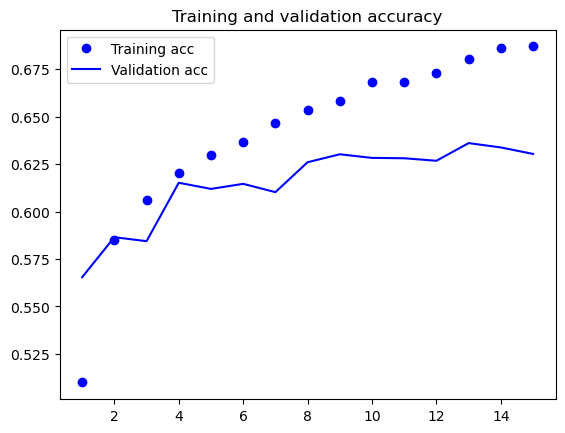

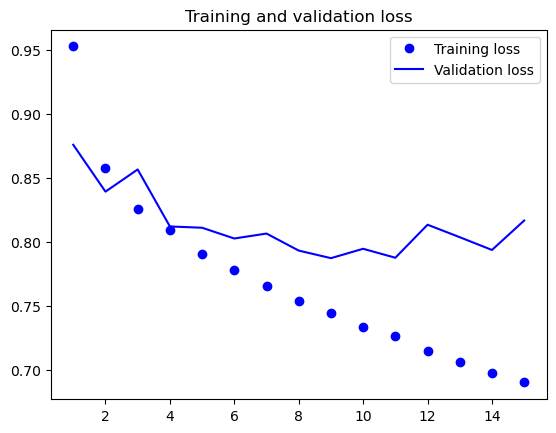

In [254]:
# Plot the Training and Validation Accuracy & Loss Scores

acc = history29vk.history['acc']
val_acc = history29vk.history['val_acc']
loss = history29vk.history['loss']
val_loss = history29vk.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [255]:
# Save the Model
model29vk.save('model29vk.h5')

### Model #30 <a id="model30"></a>

#### Pre-train word embeddings dimension: 200
[Back to Model Evaluation](#model30c)

In [257]:
glove_dir = 'C:\\Users\\xinle\\OneDrive - Ngee Ann Polytechnic\\NP\\2.2\\DL\\week 7'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400001 word vectors.


In [258]:
embedding_dim = 200
word_index = tokenizer.word_index

embedding_matrix200 = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < vocab_size:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix200[i] = embedding_vector

In [259]:
model30vk = Sequential()
model30vk.add(Embedding(vocab_size, 200, input_length=max_length))
model30vk.add(GRU(32, return_sequences=True))
model30vk.add(MaxPooling1D(pool_size=2))
model30vk.add(GRU(64))
model30vk.add(Dense(32, activation='relu'))
model30vk.add(Dense(3, activation='softmax'))

model30vk.summary()

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_51 (Embedding)    (None, 358, 200)          577000    
                                                                 
 gru_100 (GRU)               (None, 358, 32)           22464     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 179, 32)          0         
 1D)                                                             
                                                                 
 gru_101 (GRU)               (None, 64)                18816     
                                                                 
 dense_96 (Dense)            (None, 32)                2080      
                                                                 
 dense_97 (Dense)            (None, 3)                 99        
                                                     

In [260]:
model30vk.layers[0].set_weights([embedding_matrix200])
model30vk.layers[0].trainable = False
model30vk.summary()

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_51 (Embedding)    (None, 358, 200)          577000    
                                                                 
 gru_100 (GRU)               (None, 358, 32)           22464     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 179, 32)          0         
 1D)                                                             
                                                                 
 gru_101 (GRU)               (None, 64)                18816     
                                                                 
 dense_96 (Dense)            (None, 32)                2080      
                                                                 
 dense_97 (Dense)            (None, 3)                 99        
                                                     

In [261]:
model30vk.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(learning_rate=0.0005), metrics=['acc'])

history30vk = model27vk.fit(X_train, y_train, 
                          epochs=15, batch_size=25, 
                          validation_split=0.3)

Epoch 1/15
491/491 [==============================] - 115s 224ms/step - loss: 0.5420 - acc: 0.7807 - val_loss: 0.8916 - val_acc: 0.6256
Epoch 2/15
491/491 [==============================] - 125s 255ms/step - loss: 0.5287 - acc: 0.7884 - val_loss: 0.9106 - val_acc: 0.6243
Epoch 3/15
491/491 [==============================] - 98s 200ms/step - loss: 0.5189 - acc: 0.7930 - val_loss: 0.9119 - val_acc: 0.6190
Epoch 4/15
491/491 [==============================] - 101s 205ms/step - loss: 0.5080 - acc: 0.7993 - val_loss: 0.9443 - val_acc: 0.6173
Epoch 5/15
491/491 [==============================] - 100s 203ms/step - loss: 0.4951 - acc: 0.8037 - val_loss: 0.9818 - val_acc: 0.6142
Epoch 6/15
491/491 [==============================] - 98s 199ms/step - loss: 0.4855 - acc: 0.8095 - val_loss: 0.9871 - val_acc: 0.6144
Epoch 7/15
491/491 [==============================] - 102s 208ms/step - loss: 0.4731 - acc: 0.8116 - val_loss: 0.9841 - val_acc: 0.6097
Epoch 8/15
491/491 [==============================

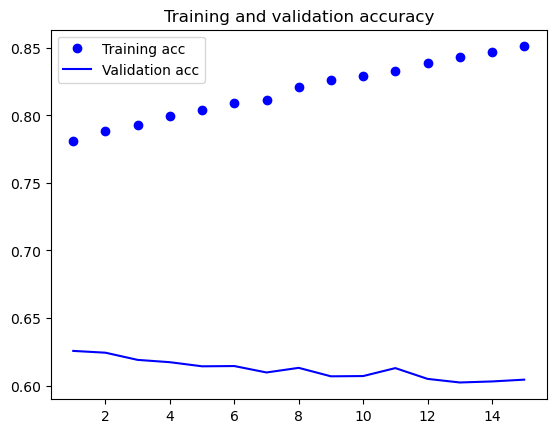

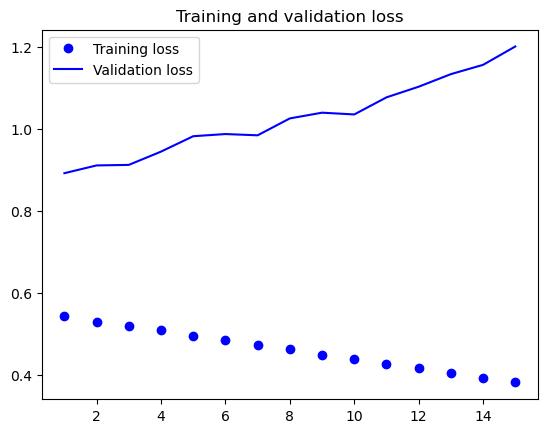

In [262]:
# Plot the Training and Validation Accuracy & Loss Scores

acc = history30vk.history['acc']
val_acc = history30vk.history['val_acc']
loss = history30vk.history['loss']
val_loss = history30vk.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [264]:
# Save the Model
model30vk.save('model30vk.h5')

### Model #31 <a id="model31"></a>

#### reduced to 15 epochs
[Back to Model Evaluation](#model31c)

In [299]:
model32vk = Sequential()
model32vk.add(Embedding(vocab_size, 8, input_length=max_length))
model32vk.add(GRU(32, return_sequences=True))
model32vk.add(MaxPooling1D(pool_size=2))
model32vk.add(GRU(64))
model32vk.add(Dense(32, activation='relu'))
model32vk.add(Dense(3, activation='softmax'))

model32vk.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(learning_rate=0.0005), metrics=['acc'])
model32vk.summary()

Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_60 (Embedding)    (None, 358, 8)            23080     
                                                                 
 gru_118 (GRU)               (None, 358, 32)           4032      
                                                                 
 max_pooling1d_14 (MaxPoolin  (None, 179, 32)          0         
 g1D)                                                            
                                                                 
 gru_119 (GRU)               (None, 64)                18816     
                                                                 
 dense_112 (Dense)           (None, 32)                2080      
                                                                 
 dense_113 (Dense)           (None, 3)                 99        
                                                     

In [300]:
history32vk = model32vk.fit(X_train, y_train, 
                          epochs=15, batch_size=25, 
                          validation_split=0.3)

Epoch 1/15
491/491 [==============================] - 107s 204ms/step - loss: 1.0134 - acc: 0.4539 - val_loss: 0.8923 - val_acc: 0.5450
Epoch 2/15
491/491 [==============================] - 97s 198ms/step - loss: 0.8696 - acc: 0.5577 - val_loss: 0.8460 - val_acc: 0.5747
Epoch 3/15
491/491 [==============================] - 103s 210ms/step - loss: 0.8369 - acc: 0.5910 - val_loss: 0.8228 - val_acc: 0.5967
Epoch 4/15
491/491 [==============================] - 99s 202ms/step - loss: 0.7989 - acc: 0.6235 - val_loss: 0.8085 - val_acc: 0.6188
Epoch 5/15
491/491 [==============================] - 100s 204ms/step - loss: 0.7711 - acc: 0.6491 - val_loss: 0.8005 - val_acc: 0.6281
Epoch 6/15
491/491 [==============================] - 104s 212ms/step - loss: 0.7529 - acc: 0.6643 - val_loss: 0.7921 - val_acc: 0.6380
Epoch 7/15
491/491 [==============================] - 96s 196ms/step - loss: 0.7344 - acc: 0.6724 - val_loss: 0.8302 - val_acc: 0.6169
Epoch 8/15
491/491 [==============================]

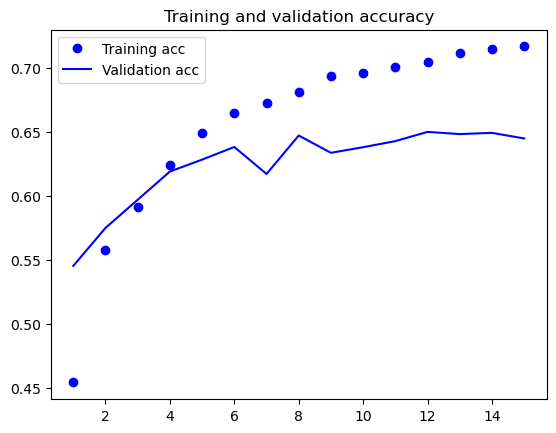

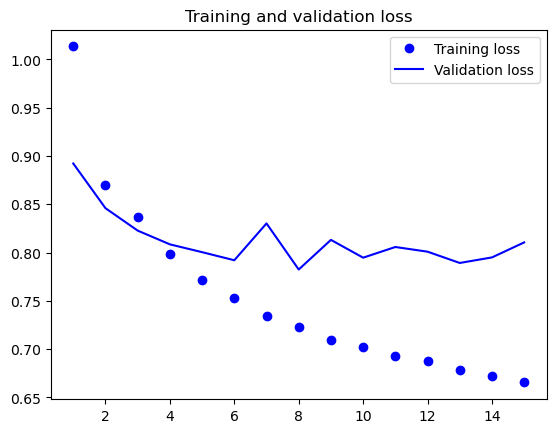

In [301]:
# Plot the Training and Validation Accuracy & Loss Scores

acc = history32vk.history['acc']
val_acc = history32vk.history['val_acc']
loss = history32vk.history['loss']
val_loss = history32vk.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [302]:
# Save the Model
model32vk.save('model32vk.h5')

### Minh's Model

In [31]:
modelminh = Sequential()

modelminh.add(Embedding(vocab_size, embedding_dim, input_length=max_length,
                    weights=[embedding_matrix100], trainable=True))
modelminh.add(Bidirectional(GRU(64, return_sequences=True)))
modelminh.add(Bidirectional(GRU(32)))
modelminh.add(Dropout(0.575))
modelminh.add(Dense(3, activation='softmax', kernel_regularizer=regularizers.l2(0.03)))

modelminh.compile(loss='categorical_crossentropy', 
                  optimizer=optimizers.RMSprop(learning_rate = 0.0006), metrics=['acc'])

In [32]:
history = modelminh.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
549/549 [==============================] - 439s 776ms/step - loss: 0.9966 - acc: 0.5401 - val_loss: 0.9230 - val_acc: 0.5494
Epoch 2/10
549/549 [==============================] - 420s 765ms/step - loss: 0.8436 - acc: 0.6195 - val_loss: 0.8307 - val_acc: 0.6050
Epoch 3/10
549/549 [==============================] - 511s 932ms/step - loss: 0.8017 - acc: 0.6457 - val_loss: 0.8134 - val_acc: 0.6303
Epoch 4/10
549/549 [==============================] - 498s 907ms/step - loss: 0.7784 - acc: 0.6595 - val_loss: 0.8253 - val_acc: 0.6179
Epoch 5/10
549/549 [==============================] - 467s 850ms/step - loss: 0.7591 - acc: 0.6690 - val_loss: 0.7869 - val_acc: 0.6426
Epoch 6/10
549/549 [==============================] - 437s 797ms/step - loss: 0.7427 - acc: 0.6829 - val_loss: 0.7709 - val_acc: 0.6503
Epoch 7/10
549/549 [==============================] - 368s 670ms/step - loss: 0.7292 - acc: 0.6893 - val_loss: 0.7956 - val_acc: 0.6231
Epoch 8/10
549/549 [============================

In [33]:
# Save the Model
modelminh.save('modelminh.h5')

### Sheryl's Model

In [28]:
modelsheryl = Sequential()
modelsheryl.add(Embedding(vocab_size, 32, input_length=max_length))
modelsheryl.add(Bidirectional(LSTM(64, recurrent_dropout=0.2, return_sequences=True)))
modelsheryl.add(Conv1D(64, 3, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
modelsheryl.add(Bidirectional(LSTM(64, recurrent_dropout=0.2, return_sequences=True)))
modelsheryl.add(MaxPooling1D(pool_size=2))
modelsheryl.add(Dropout(0.5))
modelsheryl.add(Flatten())
modelsheryl.add(Dense(units=64, activation='relu'))
modelsheryl.add(Dense(3, activation='softmax'))

modelsheryl.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0001), metrics=['acc'])

In [29]:
history = modelsheryl.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
549/549 [==============================] - 1034s 2s/step - loss: 1.4132 - acc: 0.4917 - val_loss: 1.0669 - val_acc: 0.5786
Epoch 2/10
549/549 [==============================] - 1033s 2s/step - loss: 0.9549 - acc: 0.6128 - val_loss: 0.8966 - val_acc: 0.6099
Epoch 3/10
549/549 [==============================] - 1013s 2s/step - loss: 0.8392 - acc: 0.6410 - val_loss: 0.8427 - val_acc: 0.6229
Epoch 4/10
549/549 [==============================] - 983s 2s/step - loss: 0.7924 - acc: 0.6560 - val_loss: 0.8217 - val_acc: 0.6311
Epoch 5/10
549/549 [==============================] - 901s 2s/step - loss: 0.7622 - acc: 0.6685 - val_loss: 0.8269 - val_acc: 0.6170
Epoch 6/10
549/549 [==============================] - 869s 2s/step - loss: 0.7436 - acc: 0.6735 - val_loss: 0.8184 - val_acc: 0.6220
Epoch 7/10
549/549 [==============================] - 906s 2s/step - loss: 0.7302 - acc: 0.6822 - val_loss: 0.8023 - val_acc: 0.6334
Epoch 8/10
549/549 [==============================] - 879s 2s/step

### Aislinn's Model

In [41]:
### Loaded in Aislinn's model using her weights instead
modelaislinn = Sequential()
modelaislinn.add(Embedding(vocab_size, 100, input_length=max_length,
                    weights=[embedding_matrix100], trainable=True))
modelaislinn.add(Bidirectional(LSTM(64, recurrent_regularizer=regularizers.l2(0.01), return_sequences=True)))
modelaislinn.add(Bidirectional(LSTM(64, recurrent_regularizer=regularizers.l2(0.01))))
modelaislinn.add(Dropout(0.5))
modelaislinn.add(Dense(3, activation='sigmoid'))

modelaislinn.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.00005), metrics=['acc'])

## Step 3 – Evaluate the Model using Testing Data (Individual & Group) <a id="part3"></a>

### Model #1 <a id="model1c"></a>
[To model](#model1) 

#### baseline model : embedding dimension: 8, optimizer: rmsprop

In [59]:
model1vk = keras.models.load_model('model1vk.h5')

test_loss, test_acc = model1vk.evaluate(X_test,y_test, verbose =0)
print('test acc:', test_acc) 

test acc: 0.5891431570053101


### Model #2 <a id="model2c"></a>
[To model](#model2) 

#### GRU

In [64]:
model2vk = keras.models.load_model('model2vk.h5')

test_loss, test_acc = model2vk.evaluate(X_test,y_test, verbose =0)
print('test acc:', test_acc) 

test acc: 0.607370913028717


### Model #3 <a id="model3c"></a>
[To model](#model3) 

#### LSTM

In [107]:
model3vk = keras.models.load_model('model3vk.h5')

test_loss, test_acc = model3vk.evaluate(X_test,y_test, verbose =0)
print('test acc:', test_acc) 

test acc: 0.5891431570053101


### Model #4 <a id="model4c"></a>
[To model](#model4) 

#### SimpleRNN

In [75]:
model4k = keras.models.load_model('model4vk.h5')

test_loss, test_acc = model4vk.evaluate(X_test,y_test, verbose =0)
print('test acc:', test_acc) 

test acc: 0.508249044418335


### Model #5 <a id="model5c"></a>
[To model](#model5) 

#### Conv1D 

In [94]:
model5vk = keras.models.load_model('model5vk.h5')

test_loss, test_acc = model5vk.evaluate(X_test,y_test, verbose =0)
print('test acc:', test_acc) 

test acc: 0.5995210409164429


### Model #6 <a id="model6c"></a>
[To model](#model6) 

#### Learning rate: 0.001

In [114]:
model6vk = keras.models.load_model('model6vk.h5')

test_loss, test_acc = model6vk.evaluate(X_test,y_test, verbose =0)
print('test acc:', test_acc) 

test acc: 0.6142895221710205


### Model #7 <a id="model7c"></a>
[To model](#model7) 

#### Learning rate: 0.0005

In [148]:
model7vk = keras.models.load_model('model7vk.h5')

test_loss, test_acc = model7vk.evaluate(X_test,y_test, verbose =0)
print('test acc:', test_acc) 

test acc: 0.6217402815818787


### Model #8 <a id="model8c"></a>
[To model](#model8) 

#### 2 GRU Layers

In [153]:
model8vk = keras.models.load_model('model8vk.h5')

test_loss, test_acc = model8vk.evaluate(X_test,y_test, verbose =0)
print('test acc:', test_acc) 

test acc: 0.6182810068130493


### Model #9 <a id="model9c"></a>
[To model](#model9) 

#### Increase units in GRU layers (32,64)

In [163]:
model9vk = keras.models.load_model('model9vk.h5')

test_loss, test_acc = model9vk.evaluate(X_test,y_test, verbose =0)
print('test acc:', test_acc) 

test acc: 0.6266631484031677


### Model #10 <a id="model10c"></a>
[To model](#model10) 

#### Increase units in GRU layer (64,128)

In [67]:
model10vk = keras.models.load_model('model10vk.h5')

test_loss, test_acc = model10vk.evaluate(X_test,y_test, verbose =0)
print('test acc:', test_acc)

test acc: 0.4743214547634125


### Model #11 <a id="model11c"></a>
[To model](#model11) 

#### Add another dense layer of 32 units

In [35]:
model11vk = keras.models.load_model('model11vk.h5')

test_loss, test_acc = model11vk.evaluate(X_test,y_test, verbose =0)
print('test acc:', test_acc)

test acc: 0.6448909044265747


### Model #12 <a id="model12c"></a>
[To model](#model12) 

#### Add 2 more dense layer of 64 and 32 units

In [47]:
model12vk = keras.models.load_model('model12vk.h5')

test_loss, test_acc = model12vk.evaluate(X_test,y_test, verbose =0)
print('test acc:', test_acc)

test acc: 0.6378392577171326


### Model #13 <a id="model13c"></a>
[To model](#model13) 

#### Dropout: 0.2, No. of Dropout Layer: 2

In [52]:
model13vk = keras.models.load_model('model13vk.h5')

test_loss, test_acc = model13vk.evaluate(X_test,y_test, verbose =0)
print('test acc:', test_acc)

test acc: 0.638371467590332


### Model #14 <a id="model14c"></a>
[To model](#model14) 

#### Dropout: 0.2, No. of Dropout Layer: 1

In [79]:
model14vk = keras.models.load_model('model14vk.h5')

test_loss, test_acc = model14vk.evaluate(X_test,y_test, verbose =0)
print('test acc:', test_acc)

test acc: 0.6431612372398376


### Model #15 <a id="model15c"></a>
[To model](#model15) 

#### Recurrent Dropout = 0.2, No. of dropout layer: 2

In [86]:
model15vk = keras.models.load_model('model15vk.h5')

test_loss, test_acc = model15vk.evaluate(X_test,y_test, verbose =0)
print('test acc:', test_acc)

test acc: 0.6407663822174072


### Model #16 <a id="model16c"></a>
[To model](#model16) 

#### recurrent dropout = 0.5

In [105]:
model16vk = keras.models.load_model('model16vk.h5')

test_loss, test_acc = model16vk.evaluate(X_test,y_test, verbose =0)
print('test acc:', test_acc)

test acc: 0.6386376023292542


### Model #17 <a id="model17c"></a>
[To model](#model17)

#### L2 regularizers: 0.001

In [110]:
model17vk = keras.models.load_model('model17vk.h5')

test_loss, test_acc = model17vk.evaluate(X_test,y_test, verbose =0)
print('test acc:', test_acc)

test acc: 0.6355774402618408


### Model #18 <a id="model18c"></a>
[To model](#model18)

#### L2 regularizers: 0.0001

In [134]:
model18vk = keras.models.load_model('model18vk.h5')

test_loss, test_acc = model18vk.evaluate(X_test,y_test, verbose =0)
print('test acc:', test_acc)

test acc: 0.6321181654930115


### Model #19 <a id="model19c"></a>
[To model](#model19) 

#### L1 regularizers: 0.0001 on dense layer

In [129]:
model = keras.models.load_model('model19vk.h5')

test_loss, test_acc = model19vk.evaluate(X_test,y_test, verbose =0)
print('test acc:', test_acc)

test acc: 0.6416977047920227


### Model #20 <a id="model20c"></a>
[To model](#model20) 

#### L1 regularizers: 0.0001 on GRU layer

In [141]:
model20vk = keras.models.load_model('model20vk.h5')

test_loss, test_acc = model20vk.evaluate(X_test,y_test, verbose =0)
print('test acc:', test_acc)

test acc: 0.6305215358734131


### Model #21 <a id="model21c"></a>
[To model](#model21) 

#### Optimizer: Adam

In [148]:
model21vk = keras.models.load_model('model21vk.h5')

test_loss, test_acc = model21vk.evaluate(X_test,y_test, verbose =0)
print('test acc:', test_acc)

test acc: 0.6040446758270264


### Model #22 <a id="model22c"></a>
[To model](#model22) 

#### Optimizer: SGD

In [154]:
model22vk = keras.models.load_model('model22vk.h5')

test_loss, test_acc = model22vk.evaluate(X_test,y_test, verbose =0)
print('test acc:', test_acc)

test acc: 0.33594998717308044


### Model #23 <a id="model23c"></a>
[To model](#model23) 

#### Embedding dimension: 50

In [163]:
model23vk = keras.models.load_model('model23vk.h5')

test_loss, test_acc = model23vk.evaluate(X_test,y_test, verbose =0)
print('test acc:', test_acc)

test acc: 0.631585955619812


### Model #24 <a id="model24c"></a>
[To model](#model24) 

#### Embedding dimension: 25

In [180]:
model24vk = keras.models.load_model('model24vk.h5')

test_loss, test_acc = model24vk.evaluate(X_test,y_test, verbose =0)
print('test acc:', test_acc)

test acc: 0.6305215358734131


### Model #25 <a id="model25c"></a>
[To model](#model25) 

#### Batch size:32

In [207]:
model25vk = keras.models.load_model('model25vk.h5')

test_loss, test_acc = model25vk.evaluate(X_test,y_test, verbose =0)
print('test acc:', test_acc)

test acc: 0.6349121928215027


### Model #26 <a id="model26c"></a>
[To model](#model26) 

#### Batch size: 64

In [212]:
model26vk = keras.models.load_model('model26vk.h5')

test_loss, test_acc = model26vk.evaluate(X_test,y_test, verbose =0)
print('test acc:', test_acc)

test acc: 0.6257317662239075


### Model #27 <a id="model27c"></a>
[To model](#model27) 

#### MaxPooling1D (Size =2)

In [235]:
model27vk = keras.models.load_model('model27vk.h5')

test_loss, test_acc = model27vk.evaluate(X_test,y_test, verbose =0)
print('test acc:', test_acc)

test acc: 0.6299893856048584


### Model #28 <a id="model28c"></a>
[To model](#model28) 

#### Pre-train word embeddings dimension: 50

In [248]:
model28vk = keras.models.load_model('model28vk.h5')

test_loss, test_acc = model28vk.evaluate(X_test,y_test, verbose =0)
print('test acc:', test_acc)

test acc: 0.6177487969398499


### Model #29 <a id="model29c"></a>
[To model](#model29) 

#### Pre-train word embeddings dimension: 100

In [256]:
model29vk = keras.models.load_model('model29vk.h5')

test_loss, test_acc = model29vk.evaluate(X_test,y_test, verbose =0)
print('test acc:', test_acc)

test acc: 0.6277275085449219


### Model #30 <a id="model30c"></a>
[To model](#model30) 

#### Pre-train word embeddings dimension: 200

In [265]:
model30vk = keras.models.load_model('model30vk.h5')

test_loss, test_acc = model30vk.evaluate(X_test,y_test, verbose =0)
print('test acc:', test_acc)

test acc: 0.3455295264720917


### Model #31 <a id="model31c"></a>
[To model](#model31) 

#### Reduced to 15 epoch

In [303]:
model32vk = keras.models.load_model('model32vk.h5')

test_loss, test_acc = model32vk.evaluate(X_test,y_test, verbose =0)
print('test acc:', test_acc)

test acc: 0.641564667224884


### Minh's model

In [39]:
modelminh = keras.models.load_model('modelminh.h5')

test_loss, test_acc = modelminh.evaluate(X_test,y_test, verbose =0)
print('test acc:', test_acc)

test acc: 0.6546035408973694


### Sheryl's model

In [30]:
test_loss, test_acc = modelsheryl.evaluate(X_test,y_test, verbose =0)
print('test acc:', test_acc)

test acc: 0.6405002474784851


### Aislinn's model

In [49]:
modelaislinn = keras.models.load_model('aislinn.h5')

test_loss, test_acc = modelaislinn.evaluate(X_test,y_test, verbose =0)
print('test acc:', test_acc)

test acc: 0.32876530289649963


## Step 4 – Use the Best Model to make prediction (Group) <a id="part4"></a>

In [35]:
modelminh = keras.models.load_model('modelminh.h5')

In [44]:
text_input = np.array([input()])

i love this app!! it offers a user-friendly interface and offers subtitles in multiple languages


In [45]:
# convert the user input into numeric tensor

texts = text_input.tolist()
texts = [text.lower() for text in texts]
#user_input = tokenizer.texts_to_sequences([texts])
#user_input = pad_sequences(user_input, maxlen=max_length)

In [46]:
# Preprocess the texts
preprocessed_texts = []
for text in texts:
    tokens = word_tokenize(text)
    #tokens = [token for token in tokens if token.lower() not in stop_words]
    #tokens = [stemmer.stem(token) for token in tokens]
    tokens = [lemma.lemmatize(token) for token in tokens]
    preprocessed_text = " ".join(tokens)
    preprocessed_texts.append(preprocessed_text)

sequences = tokenizer.texts_to_sequences(preprocessed_texts)

# Pad the sequences to have the same length
user_input = pad_sequences(sequences, maxlen=max_length)

In [47]:
# show the model output using predict function

predictions = modelminh.predict(user_input)

predicted_class = np.argmax(predictions)

if (predicted_class == 0):
    print("Negative Sentiment")
elif (predicted_class == 1):
    print("Neutral Sentiment")
else:
    print("Positive Sentiment")

1/1 [==============================] - 0s 82ms/step
Positive Sentiment


[back to top](#top)